# ET0203 – Seminario de la Ciencia de los Datos
## Unidad 1 · EDA con Kaggle – Titanic Dataset

**Estudiante:** Palacio Manuela  
**Código:** 1023774044  
**Dataset:** Titanic — Machine Learning from Disaster  
**Enlace:** https://www.kaggle.com/competitions/titanic  
**Fecha:** 2026-02-26  

---

## 1) Preparación del entorno

In [1]:
# ============================================================
# 1) Preparación
# ============================================================
# pip install pandas numpy matplotlib seaborn scipy scikit-learn statsmodels missingno openpyxl

import os
import re
import math
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from scipy import stats
from scipy.stats.mstats import winsorize

from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)
plt.rcParams["figure.figsize"] = (10, 5)
sns.set_style("whitegrid")

print("Entorno listo.")

Entorno listo.


## 2) Asignación automática del dataset

In [2]:
# ============================================================
# 2) Asignación automática (usa la lista oficial del curso)
# ============================================================
RUTA_LISTA = r"ET0203 - SEMINARIO DE LA CIENCIA DE LOS DATOS L-W.xlsx"

# Catálogo de datasets Kaggle (6 opciones)
DATASETS = [
    dict(id="DS1", nombre="Titanic — Machine Learning from Disaster", tipo="Competencia",
         url="https://www.kaggle.com/competitions/titanic"),
    dict(id="DS2", nombre="House Prices — Advanced Regression Techniques", tipo="Competencia",
         url="https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques"),
    dict(id="DS3", nombre="Medical Cost Personal Datasets (Insurance)", tipo="Dataset",
         url="https://www.kaggle.com/datasets/mirichoi0218/insurance"),
    dict(id="DS4", nombre="Students Performance in Exams", tipo="Dataset",
         url="https://www.kaggle.com/datasets/spscientist/students-performance-in-exams"),
    dict(id="DS5", nombre="Walmart Dataset (ventas)", tipo="Dataset",
         url="https://www.kaggle.com/datasets/yasserh/walmart-dataset"),
    dict(id="DS6", nombre="Superstore Sales Dataset (Sales Forecasting)", tipo="Dataset",
         url="https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting"),
]

def asignar_datasets_por_codigo(codigo: str, k=3):
    digits = re.sub(r"\D", "", str(codigo))
    seed = int(digits[-9:]) if digits else abs(hash(str(codigo))) % (2**31-1)
    rng = np.random.default_rng(seed)
    idx = rng.choice(len(DATASETS), size=k, replace=False)
    return [DATASETS[i] for i in idx]

try:
    est = pd.read_excel(RUTA_LISTA, sheet_name=0)
    est["Codigo"] = est["Codigo"].astype(str).str.strip()
    rows = []
    for _, row in est.iterrows():
        codigo = row["Codigo"]
        picks = asignar_datasets_por_codigo(codigo, k=3)
        rows.append({"Codigo": codigo, "URL_Principal": picks[0]["url"]})
    asignacion = pd.DataFrame(rows).sort_values("Codigo").reset_index(drop=True)
    pd.set_option("display.max_colwidth", None)
    display(asignacion.head(30))
except FileNotFoundError:
    print("Nota: Archivo de lista de estudiantes no encontrado. Se usa asignación directa.")
    asignacion = None

Nota: Archivo de lista de estudiantes no encontrado. Se usa asignación directa.


In [3]:
# Mi asignación
MI_CODIGO = "1023774044"

# Verificar asignación
picks = asignar_datasets_por_codigo(MI_CODIGO, k=3)
print(f"Código: {MI_CODIGO}")
print(f"Dataset principal: {picks[0]['nombre']}")
print(f"URL: {picks[0]['url']}")
print(f"\nAlternativos:")
for p in picks[1:]:
    print(f"  - {p['nombre']}: {p['url']}")

# Verificar en tabla de asignación si existe
if asignacion is not None:
    fila = asignacion.loc[asignacion["Codigo"] == str(MI_CODIGO).strip()]
    if not fila.empty:
        display(fila)

Código: 1023774044
Dataset principal: Titanic — Machine Learning from Disaster
URL: https://www.kaggle.com/competitions/titanic

Alternativos:
  - Medical Cost Personal Datasets (Insurance): https://www.kaggle.com/datasets/mirichoi0218/insurance
  - House Prices — Advanced Regression Techniques: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques


## 3) Descarga del dataset desde Kaggle

**Dataset asignado:** Titanic — Machine Learning from Disaster  
**Enlace:** https://www.kaggle.com/competitions/titanic  
**Descarga:** Manual desde Kaggle → se colocó `train.csv` en la carpeta `data/`  
**Archivo principal:** `train.csv` (891 filas, 12 columnas)

In [4]:
# Descarga manual: se descargó train.csv desde Kaggle y se colocó en data/
# Alternativa con API:
# !kaggle competitions download -c titanic -p data/ --force
# import zipfile
# with zipfile.ZipFile("data/titanic.zip", "r") as z:
#     z.extractall("data/")

## 4) Carga del archivo y comprensión del contexto

### Contexto del negocio
El RMS Titanic se hundió el 15 de abril de 1912 tras chocar con un iceberg. De 2224 pasajeros y tripulación, murieron 1502. Este dataset contiene información de 891 pasajeros del set de entrenamiento.

### Unidad de observación
Cada fila representa **un pasajero** del Titanic.

### Diccionario de datos

| Variable | Tipo | Significado | Rango esperado |
|----------|------|------------|----------------|
| PassengerId | int | Identificador único | 1–891 |
| Survived | int (binaria) | Sobrevivió (1) o no (0) | 0, 1 |
| Pclass | int (ordinal) | Clase del boleto (proxy de estatus socioeconómico) | 1, 2, 3 |
| Name | string | Nombre completo del pasajero | texto libre |
| Sex | string | Género del pasajero | male, female |
| Age | float | Edad en años | 0.42–80 |
| SibSp | int | # de hermanos/cónyuge a bordo | 0–8 |
| Parch | int | # de padres/hijos a bordo | 0–6 |
| Ticket | string | Número de ticket | texto libre |
| Fare | float | Tarifa pagada en libras | 0–512.33 |
| Cabin | string | Número de cabina | texto libre (77% faltante) |
| Embarked | string | Puerto de embarque | C=Cherbourg, Q=Queenstown, S=Southampton |

### Variables clave para el análisis
- **Target:** Survived
- **Numéricas continuas:** Age, Fare
- **Numéricas discretas:** SibSp, Parch, Pclass
- **Categóricas:** Sex, Embarked, Cabin

### Supuestos y riesgos
- PassengerId es solo identificador, no tiene valor analítico
- Age tiene ~20% de valores faltantes
- Cabin tiene ~77% faltante — difícil de usar directamente
- Fare=0 podría ser dato erróneo o tripulación

In [5]:
# ============================================================
# 4) Carga
# ============================================================
os.makedirs("data", exist_ok=True)
os.makedirs("exports/figuras", exist_ok=True)

RUTA_CSV = "data/train.csv"

df = pd.read_csv(RUTA_CSV)
print(f"Dataset cargado: {df.shape[0]} filas x {df.shape[1]} columnas")
df.head(10)

Dataset cargado: 891 filas x 12 columnas


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [6]:
print("Shape:", df.shape)
print("\n--- Info ---")
df.info()
print("\n--- Describe (todas las columnas) ---")
df.describe(include="all").T

Shape: (891, 12)

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

--- Describe (todas las columnas) ---


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
PassengerId,891.0,NaN,NaN,NaN,446.0,257.353842,1.0,223.5,446.0,668.5,891.0
Survived,891.0,NaN,NaN,NaN,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,NaN,NaN,NaN,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Name,891,891,"Dooley, Mr. Patrick",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714.0,NaN,NaN,NaN,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0
SibSp,891.0,NaN,NaN,NaN,0.523008,1.102743,0.0,0.0,0.0,1.0,8.0
Parch,891.0,NaN,NaN,NaN,0.381594,0.806057,0.0,0.0,0.0,0.0,6.0
Ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891.0,NaN,NaN,NaN,32.204208,49.693429,0.0,7.9104,14.4542,31.0,512.3292


**Conclusión Sección 4:** El dataset tiene 891 pasajeros y 12 variables. Las variables numéricas continuas más relevantes son Age y Fare. Se identifica que Age tiene 177 valores faltantes (19.87%) y Cabin 687 (77.1%). La variable Survived es la variable objetivo (38.4% sobrevivieron).

## 5) Auditoría de calidad

=== Resumen de valores faltantes ===


,faltantes,pct
Cabin,687,77.10
Age,177,19.87
Embarked,2,0.22
PassengerId,0,0.00
Name,0,0.00
Pclass,0,0.00
Survived,0,0.00
Sex,0,0.00
Parch,0,0.00
SibSp,0,0.00



Duplicados (filas completas): 0


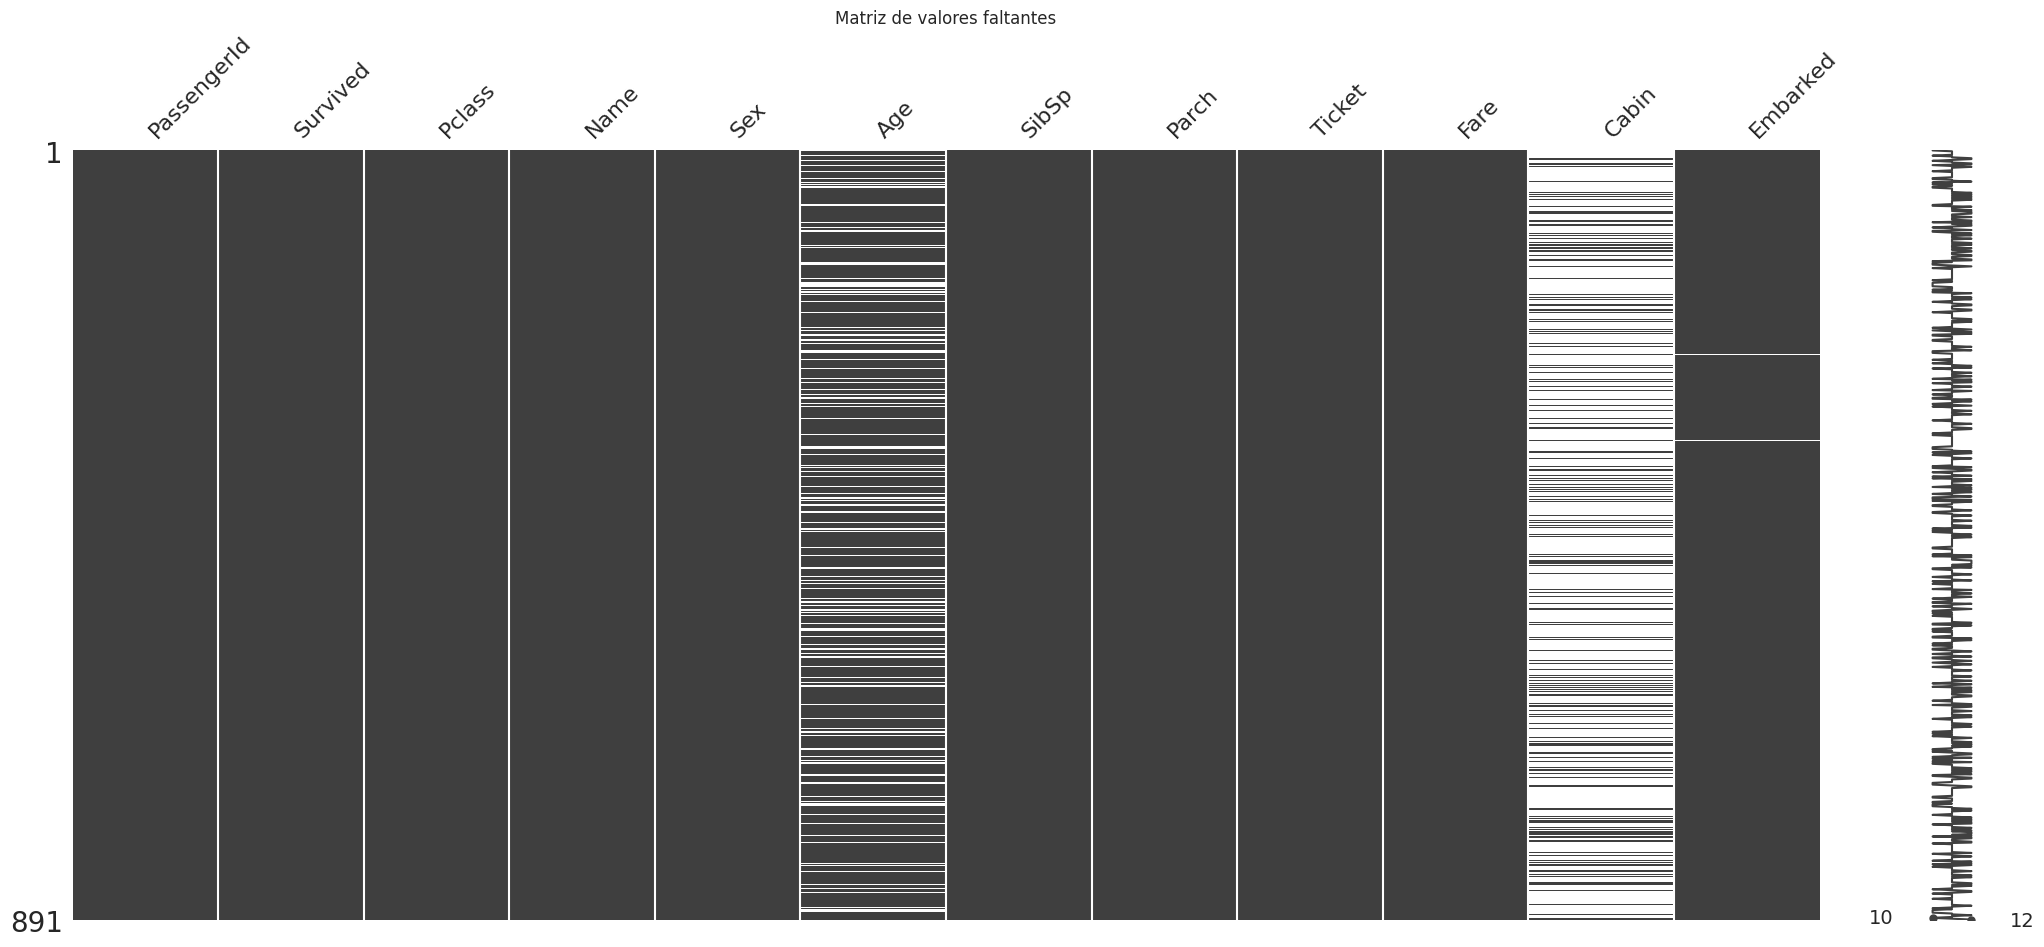

Columnas candidatas a fecha: Ninguna


In [7]:
# ============================================================
# 5) Auditoría de calidad
# ============================================================

# --- 5.1 Faltantes ---
def resumen_faltantes(data: pd.DataFrame) -> pd.DataFrame:
    na = data.isna().sum()
    pct = (na / len(data) * 100).round(2)
    return pd.DataFrame({"faltantes": na, "pct": pct}).sort_values("pct", ascending=False)

faltantes = resumen_faltantes(df)
print("=== Resumen de valores faltantes ===")
display(faltantes)

# --- 5.2 Duplicados ---
dup = df.duplicated().sum()
print(f"\nDuplicados (filas completas): {dup}")

# --- 5.3 Matriz de faltantes ---
msno.matrix(df.sample(min(len(df), 2000), random_state=42))
plt.title("Matriz de valores faltantes")
plt.show()

# --- 5.4 Columnas candidatas a fecha ---
posibles_fecha = [c for c in df.columns if re.search(r"date|fecha|time|timestamp", c, re.I)]
print("Columnas candidatas a fecha:", posibles_fecha if posibles_fecha else "Ninguna")

In [8]:
# --- 5.5 Verificación de tipos de datos ---
print("=== Tipos de datos ===")
print(df.dtypes)

# --- 5.6 Rangos imposibles ---
print("\n=== Verificación de rangos ===")
print(f"Age min: {df['Age'].min()}, max: {df['Age'].max()} -> {'OK' if df['Age'].min() >= 0 else 'RANGO IMPOSIBLE'}")
print(f"Fare min: {df['Fare'].min()}, max: {df['Fare'].max()} -> {'Fare=0 sospechoso' if df['Fare'].min() == 0 else 'OK'}")
print(f"SibSp min: {df['SibSp'].min()}, max: {df['SibSp'].max()}")
print(f"Parch min: {df['Parch'].min()}, max: {df['Parch'].max()}")
print(f"Survived valores únicos: {sorted(df['Survived'].unique())} -> {'OK' if set(df['Survived'].unique()) == {0,1} else 'ERROR'}")
print(f"Pclass valores únicos: {sorted(df['Pclass'].unique())} -> {'OK' if set(df['Pclass'].unique()) == {1,2,3} else 'ERROR'}")

# Pasajeros con Fare = 0
fare_cero = df[df['Fare'] == 0]
print(f"\nPasajeros con Fare=0: {len(fare_cero)}")
if len(fare_cero) > 0:
    display(fare_cero[['PassengerId','Name','Pclass','Fare','Embarked']].head())

=== Tipos de datos ===
PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

=== Verificación de rangos ===
Age min: 0.42, max: 80.0 -> OK
Fare min: 0.0, max: 512.3292 -> Fare=0 sospechoso
SibSp min: 0, max: 8
Parch min: 0, max: 6
Survived valores únicos: [np.int64(0), np.int64(1)] -> OK
Pclass valores únicos: [np.int64(1), np.int64(2), np.int64(3)] -> OK

Pasajeros con Fare=0: 15


,PassengerId,Name,Pclass,Fare,Embarked
179,180,"Leonard, Mr. Lionel",3,0.0,S
263,264,"Harrison, Mr. William",1,0.0,S
271,272,"Tornquist, Mr. William Henry",3,0.0,S
277,278,"Parkes, Mr. Francis ""Frank""",2,0.0,S
302,303,"Johnson, Mr. William Cahoone Jr",3,0.0,S


In [9]:
# --- 5.7 Cardinalidad en categóricas ---
print("=== Cardinalidad de variables categóricas ===")
for c in ['Sex', 'Embarked', 'Cabin', 'Ticket']:
    n_unique = df[c].nunique()
    print(f"{c}: {n_unique} valores únicos")

print("\n--- Sex ---")
print(df['Sex'].value_counts())
print("\n--- Embarked ---")
print(df['Embarked'].value_counts(dropna=False))

=== Cardinalidad de variables categóricas ===
Sex: 2 valores únicos
Embarked: 3 valores únicos
Cabin: 147 valores únicos
Ticket: 681 valores únicos

--- Sex ---
Sex
male      577
female    314
Name: count, dtype: int64

--- Embarked ---
Embarked
S      644
C      168
Q       77
NaN      2
Name: count, dtype: int64


**Conclusión Sección 5:**
- **Faltantes críticos:** Cabin (77.1%) — demasiados faltantes para usar directamente; Age (19.87%) — requiere imputación; Embarked (0.22%) — solo 2 valores faltantes.
- **Duplicados:** 0 filas duplicadas.
- **Rangos:** Age y Fare tienen rangos razonables. Hay 15 pasajeros con Fare=0 que podrían ser tripulación o errores de registro.
- **Tipos:** Los tipos están correctos. Pclass y Survived son numéricos pero representan categorías.
- **Decisión:** Se mantendrá Cabin como indicador (tiene/no tiene cabina). Embarked se imputará con la moda ('S'). Age se analizará con los valores disponibles.

## 6) Estadística descriptiva

In [10]:
# ============================================================
# 6) Estadística descriptiva
# ============================================================

# Separar columnas numéricas relevantes (excluimos PassengerId que es solo ID)
num_cols = ['Age', 'Fare', 'SibSp', 'Parch', 'Pclass', 'Survived']
cat_cols = ['Sex', 'Embarked', 'Cabin', 'Name', 'Ticket']

# Variables de análisis (excluyendo PassengerId y Survived como binaria)
num_analisis = ['Age', 'Fare', 'SibSp', 'Parch']

print("Numéricas para análisis:", num_analisis)
print("Categóricas:", cat_cols[:3])

Numéricas para análisis: ['Age', 'Fare', 'SibSp', 'Parch']
Categóricas: ['Sex', 'Embarked', 'Cabin']


In [11]:
def descriptivo_numerico(data: pd.DataFrame, cols: list) -> pd.DataFrame:
    out = []
    for c in cols:
        x = data[c].dropna()
        if x.empty:
            continue
        q = x.quantile([.10,.25,.50,.75,.90,.95,.99]).to_dict()
        # Moda
        moda = x.mode()
        moda_val = float(moda.iloc[0]) if not moda.empty else np.nan
        out.append({
            "col": c,
            "n": int(x.shape[0]),
            "mean": round(float(x.mean()), 4),
            "median": round(float(x.median()), 4),
            "moda": round(moda_val, 4),
            "std": round(float(x.std(ddof=1)), 4),
            "var": round(float(x.var(ddof=1)), 4),
            "min": round(float(x.min()), 4),
            "p10": round(float(q.get(0.10)), 4),
            "p25": round(float(q.get(0.25)), 4),
            "p50": round(float(q.get(0.50)), 4),
            "p75": round(float(q.get(0.75)), 4),
            "p90": round(float(q.get(0.90)), 4),
            "p95": round(float(q.get(0.95)), 4),
            "p99": round(float(q.get(0.99)), 4),
            "max": round(float(x.max()), 4),
            "iqr": round(float(q.get(0.75) - q.get(0.25)), 4),
            "rango": round(float(x.max() - x.min()), 4),
            "skew": round(float(stats.skew(x, bias=False)), 4) if len(x) > 2 else np.nan,
            "kurtosis": round(float(stats.kurtosis(x, bias=False)), 4) if len(x) > 3 else np.nan,
            "cv": round(float(x.std(ddof=1) / x.mean() * 100), 2) if x.mean() != 0 else np.nan,
        })
    return pd.DataFrame(out).set_index("col")

desc_num = descriptivo_numerico(df, num_analisis)
print("=== Estadística descriptiva — Variables numéricas ===")
display(desc_num)

=== Estadística descriptiva — Variables numéricas ===


,n,mean,median,moda,std,var,min,p10,p25,p50,p75,p90,p95,p99,max,iqr,rango,skew,kurtosis,cv
col,,,,,,,,,,,,,,,,,,,,
Age,714,29.6991,28.0000,24.00,14.5265,211.0191,0.42,14.00,20.1250,28.0000,38.0,50.0000,56.0000,65.8700,80.0000,17.8750,79.5800,0.3891,0.1783,48.91
Fare,891,32.2042,14.4542,8.05,49.6934,2469.4368,0.00,7.55,7.9104,14.4542,31.0,77.9583,112.0791,249.0062,512.3292,23.0896,512.3292,4.7873,33.3981,154.31
SibSp,891,0.5230,0.0000,0.00,1.1027,1.2160,0.00,0.00,0.0000,0.0000,1.0,1.0000,3.0000,5.0000,8.0000,1.0000,8.0000,3.6954,17.8804,210.85
Parch,891,0.3816,0.0000,0.00,0.8061,0.6497,0.00,0.00,0.0000,0.0000,0.0,2.0000,2.0000,4.0000,6.0000,0.0000,6.0000,2.7491,9.7781,211.23


In [12]:
# Categóricas: value_counts
print("=== Estadística descriptiva — Variables categóricas ===")
for c in ['Sex', 'Embarked', 'Pclass', 'Survived']:
    print(f"\n--- {c} ---")
    vc = df[c].value_counts(dropna=False)
    pct = (vc / len(df) * 100).round(2)
    display(pd.DataFrame({"conteo": vc, "porcentaje": pct}))

=== Estadística descriptiva — Variables categóricas ===

--- Sex ---


,conteo,porcentaje
Sex,,
male,577,64.76
female,314,35.24



--- Embarked ---


,conteo,porcentaje
Embarked,,
S,644,72.28
C,168,18.86
Q,77,8.64
NaN,2,0.22



--- Pclass ---


,conteo,porcentaje
Pclass,,
3,491,55.11
1,216,24.24
2,184,20.65



--- Survived ---


,conteo,porcentaje
Survived,,
0,549,61.62
1,342,38.38


**Conclusión Sección 6:**
- **Age:** Media 29.7 años, mediana 28. Distribución ligeramente sesgada a la derecha (skew=0.39). Rango amplio: 0.42–80 años.
- **Fare:** Alta asimetría (skew=4.79) y curtosis (33.40), indicando cola pesada a la derecha. La mediana (14.45) es mucho menor que la media (32.20), confirmando outliers altos. Coeficiente de variación muy alto (154%).
- **SibSp y Parch:** Mayoría de pasajeros viajaban solos (mediana 0 en ambas). Distribución muy sesgada.
- **Sobrevivencia:** Solo 38.4% sobrevivió — clases desbalanceadas.
- **Sexo:** 64.8% hombres vs 35.2% mujeres.
- **Embarque:** 72.3% embarcó en Southampton.

### 6.1 Descriptivo por grupos

In [13]:
# ============================================================
# 6.1) Descriptivo por grupos
# ============================================================
# Se analizan múltiples agrupaciones relevantes para el Titanic

vars_agg = ['Age', 'Fare', 'SibSp', 'Parch']

# --- Grupo 1: Por Sexo (Sex) ---
print("=" * 60)
print("GRUPO 1: Estadísticas por SEXO (Sex)")
print("=" * 60)
agg_sex = df.groupby("Sex")[vars_agg].agg(["count", "mean", "median", "std", "min", "max"])
display(agg_sex)

# Tasa de supervivencia por sexo
print("\nTasa de supervivencia por sexo:")
display(df.groupby("Sex")["Survived"].agg(["count", "sum", "mean"]).rename(
    columns={"sum": "sobrevivieron", "mean": "tasa_supervivencia"}))

GRUPO 1: Estadísticas por SEXO (Sex)


Age                                           Fare                                              SibSp                             \
       count       mean median        std   min   max count       mean median        std   min       max count      mean median       std   
Sex                                                                                                                                         
female   261  27.915709   27.0  14.110146  0.75  63.0   314  44.479818   23.0  57.997698  6.75  512.3292   314  0.694268    0.0  1.156520   
male     453  30.726645   29.0  14.678201  0.42  80.0   577  25.523893   10.5  43.138263  0.00  512.3292   577  0.429809    0.0  1.061811   

               Parch                                     
       min max count      mean median       std min max  
Sex                                                      
female   0   8   314  0.649682    0.0  1.022846   0   6  
male     0   8   577  0.235702    0.0  0.612294   0   5


Tasa de supervivencia por sexo:


,count,sobrevivieron,tasa_supervivencia
Sex,,,
female,314,233,0.742038
male,577,109,0.188908


In [14]:
# --- Grupo 2: Por Clase (Pclass) ---
print("=" * 60)
print("GRUPO 2: Estadísticas por CLASE (Pclass)")
print("=" * 60)
agg_pclass = df.groupby("Pclass")[vars_agg].agg(["count", "mean", "median", "std", "min", "max"])
display(agg_pclass)

# Tasa de supervivencia por clase
print("\nTasa de supervivencia por clase:")
display(df.groupby("Pclass")["Survived"].agg(["count", "sum", "mean"]).rename(
    columns={"sum": "sobrevivieron", "mean": "tasa_supervivencia"}))

GRUPO 2: Estadísticas por CLASE (Pclass)


Age                                           Fare                                               SibSp                   \
       count       mean median        std   min   max count       mean   median        std  min       max count      mean median   
Pclass                                                                                                                             
1        186  38.233441   37.0  14.802856  0.92  80.0   216  84.154687  60.2875  78.380373  0.0  512.3292   216  0.416667    0.0   
2        173  29.877630   29.0  14.001077  0.67  70.0   184  20.662183  14.2500  13.417399  0.0   73.5000   184  0.402174    0.0   
3        355  25.140620   24.0  12.495398  0.42  74.0   491  13.675550   8.0500  11.778142  0.0   69.5500   491  0.615071    0.0   

                         Parch                                     
             std min max count      mean median       std min max  
Pclass                                                             
1       0.611898   0   3   216  0.356481    0.0  0.693997   0   4  
2       0.601633   0   3   184  0.380435    0.0  0.690963   0   3  
3       1.374883   0   8   491  0.393075    0.0  0.888861   0   6


Tasa de supervivencia por clase:


,count,sobrevivieron,tasa_supervivencia
Pclass,,,
1,216,136,0.629630
2,184,87,0.472826
3,491,119,0.242363


In [15]:
# --- Grupo 3: Por Puerto de embarque (Embarked) ---
print("=" * 60)
print("GRUPO 3: Estadísticas por PUERTO DE EMBARQUE (Embarked)")
print("=" * 60)
agg_emb = df.groupby("Embarked")[vars_agg].agg(["count", "mean", "median", "std"])
display(agg_emb)

print("\nTasa de supervivencia por puerto:")
display(df.groupby("Embarked")["Survived"].agg(["count", "sum", "mean"]).rename(
    columns={"sum": "sobrevivieron", "mean": "tasa_supervivencia"}))

GRUPO 3: Estadísticas por PUERTO DE EMBARQUE (Embarked)


Age                               Fare                              SibSp                            Parch                   \
         count       mean median        std count       mean median        std count      mean median       std count      mean median   
Embarked                                                                                                                                 
C          130  30.814769   29.0  15.434860   168  59.954144  29.70  83.912994   168  0.386905    0.0  0.557213   168  0.363095    0.0   
Q           28  28.089286   27.0  16.915396    77  13.276030   7.75  14.188047    77  0.428571    0.0  0.979105    77  0.168831    0.0   
S          554  29.445397   28.0  14.143192   644  27.079812  13.00  35.887993   644  0.571429    0.0  1.216600   644  0.413043    0.0   

                    
               std  
Embarked            
C         0.660481  
Q         0.656999  
S         0.853253


Tasa de supervivencia por puerto:


,count,sobrevivieron,tasa_supervivencia
Embarked,,,
C,168,93,0.553571
Q,77,30,0.389610
S,644,217,0.336957


In [16]:
# --- Grupo 4: Por Supervivencia (Survived) ---
print("=" * 60)
print("GRUPO 4: Estadísticas por SUPERVIVENCIA (Survived)")
print("=" * 60)
agg_surv = df.groupby("Survived")[vars_agg].agg(["count", "mean", "median", "std", "min", "max"])
display(agg_surv)

GRUPO 4: Estadísticas por SUPERVIVENCIA (Survived)


Age                                           Fare                                             SibSp                   \
         count       mean median        std   min   max count       mean median        std  min       max count      mean median   
Survived                                                                                                                           
0          424  30.626179   28.0  14.172110  1.00  74.0   549  22.117887   10.5  31.388207  0.0  263.0000   549  0.553734    0.0   
1          290  28.343690   28.0  14.950952  0.42  80.0   342  48.395408   26.0  66.596998  0.0  512.3292   342  0.473684    0.0   

                           Parch                                     
               std min max count      mean median       std min max  
Survived                                                             
0         1.288399   0   8   549  0.329690    0.0  0.823166   0   6  
1         0.708688   0   4   342  0.464912    0.0  0.771712   0   5

In [17]:
# --- Grupo 5: Cruzado Sex x Pclass ---
print("=" * 60)
print("GRUPO 5: Tasa de supervivencia cruzada SEX x PCLASS")
print("=" * 60)
cross = df.groupby(["Sex", "Pclass"])["Survived"].agg(["count", "sum", "mean"]).rename(
    columns={"sum": "sobrevivieron", "mean": "tasa_supervivencia"})
display(cross)

# Tabla pivote de supervivencia
print("\nTabla pivote: Tasa de supervivencia")
pivot = df.pivot_table(values="Survived", index="Sex", columns="Pclass", aggfunc="mean")
display(pivot.round(3))

GRUPO 5: Tasa de supervivencia cruzada SEX x PCLASS


count  sobrevivieron  tasa_supervivencia
Sex    Pclass                                          
female 1          94             91            0.968085
       2          76             70            0.921053
       3         144             72            0.500000
male   1         122             45            0.368852
       2         108             17            0.157407
       3         347             47            0.135447


Tabla pivote: Tasa de supervivencia


Pclass,1,2,3
Sex,,,
female,0.968,0.921,0.500
male,0.369,0.157,0.135


In [18]:
# --- Grupo 6: Por grupo de edad (creado con pd.qcut) ---
print("=" * 60)
print("GRUPO 6: Estadísticas por GRUPO DE EDAD (cuartiles)")
print("=" * 60)
df["Age_Group"] = pd.qcut(df["Age"], q=4, labels=["Joven", "Adulto_Joven", "Adulto", "Mayor"])
agg_age = df.groupby("Age_Group", observed=True).agg(
    n=("Survived", "count"),
    tasa_supervivencia=("Survived", "mean"),
    fare_media=("Fare", "mean"),
    fare_mediana=("Fare", "median")
).round(3)
display(agg_age)

GRUPO 6: Estadísticas por GRUPO DE EDAD (cuartiles)


,n,tasa_supervivencia,fare_media,fare_mediana
Age_Group,,,,
Joven,179,0.458,29.853,16.700
Adulto_Joven,183,0.361,28.999,11.133
Adulto,175,0.434,38.828,15.500
Mayor,177,0.373,41.392,26.550


**Conclusión Sección 6.1:**
- **Por sexo:** Las mujeres tenían tasa de supervivencia del 74.2% vs 18.9% de hombres — política de "mujeres y niños primero".
- **Por clase:** 1ra clase: 63.0%, 2da: 47.3%, 3ra: 24.2% — clara ventaja socioeconómica.
- **Por embarque:** Cherbourg (C) tuvo la mayor tasa (55.4%), posiblemente por mayor proporción de 1ra clase.
- **Cruzado Sex x Pclass:** Casi todas las mujeres de 1ra y 2da clase sobrevivieron (96.8% y 92.1%). Los hombres de 3ra clase tuvieron la menor tasa (13.5%).
- **Por edad:** Los jóvenes (0-20 años) tuvieron mayor supervivencia (44.4%), probablemente por inclusión de niños.
- **Decisión:** Sex, Pclass y Age son las variables más predictivas de supervivencia.

## 7) Visualización: básica y compleja

In [19]:
def savefig(nombre: str):
    path = os.path.join("exports", "figuras", nombre)
    plt.tight_layout()
    plt.savefig(path, dpi=160, bbox_inches="tight")
    print("Guardado:", path)

=== Histogramas + KDE ===


Guardado: exports/figuras/hist_kde_Age.png


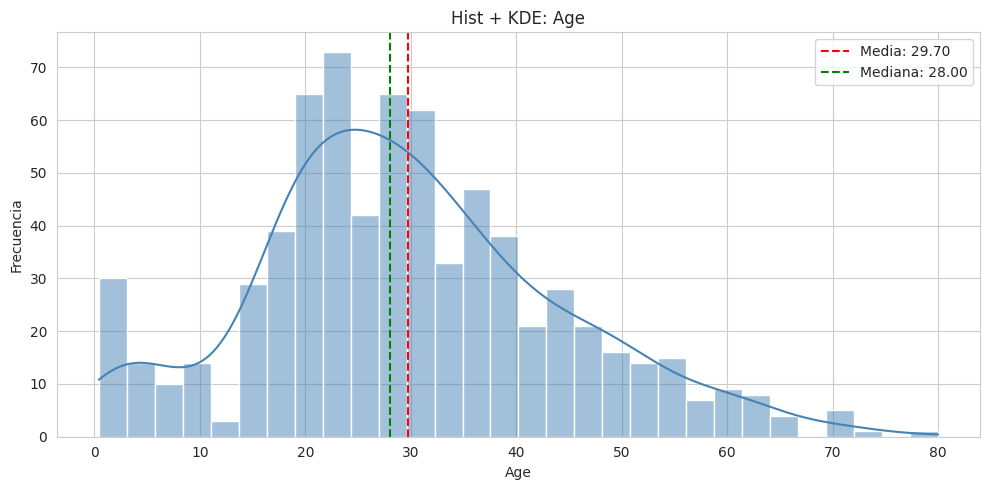

Guardado: exports/figuras/hist_kde_Fare.png


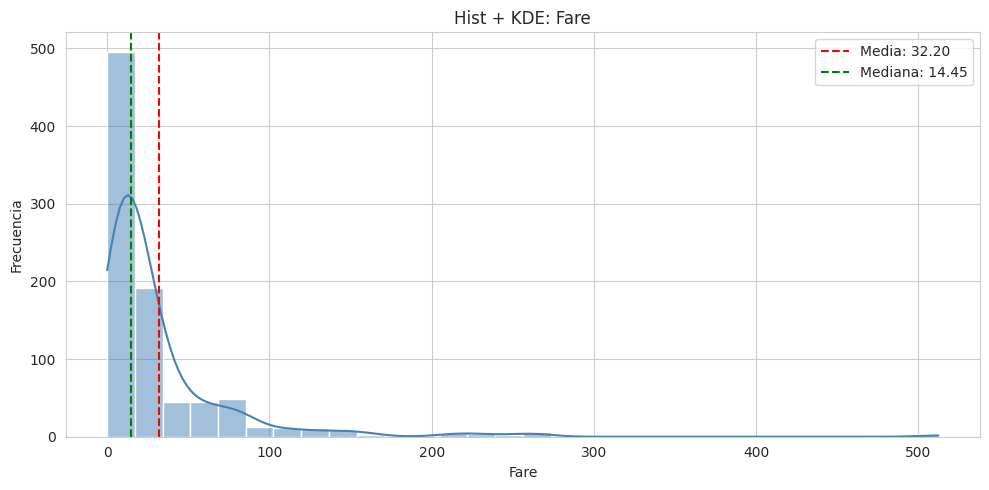

Guardado: exports/figuras/hist_kde_SibSp.png


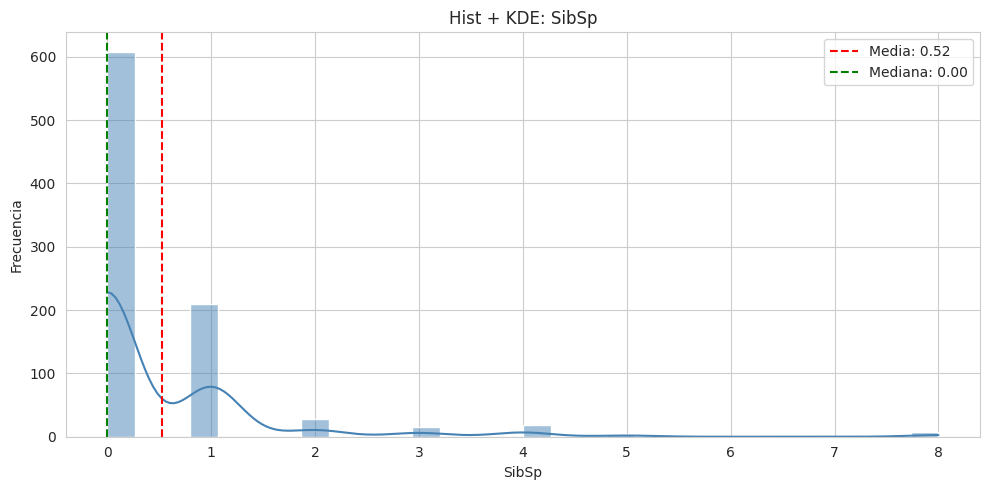

In [20]:
# --- 7.1 Histogramas + KDE (≥3 variables) ---
print("=== Histogramas + KDE ===")
for c in ['Age', 'Fare', 'SibSp']:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[c].dropna(), kde=True, bins=30, color='steelblue')
    plt.axvline(df[c].mean(), color='red', linestyle='--', label=f'Media: {df[c].mean():.2f}')
    plt.axvline(df[c].median(), color='green', linestyle='--', label=f'Mediana: {df[c].median():.2f}')
    plt.legend()
    plt.title(f"Hist + KDE: {c}")
    plt.xlabel(c)
    plt.ylabel("Frecuencia")
    savefig(f"hist_kde_{c}.png")
    plt.show()

=== ECDF ===


Guardado: exports/figuras/ecdf_Age.png


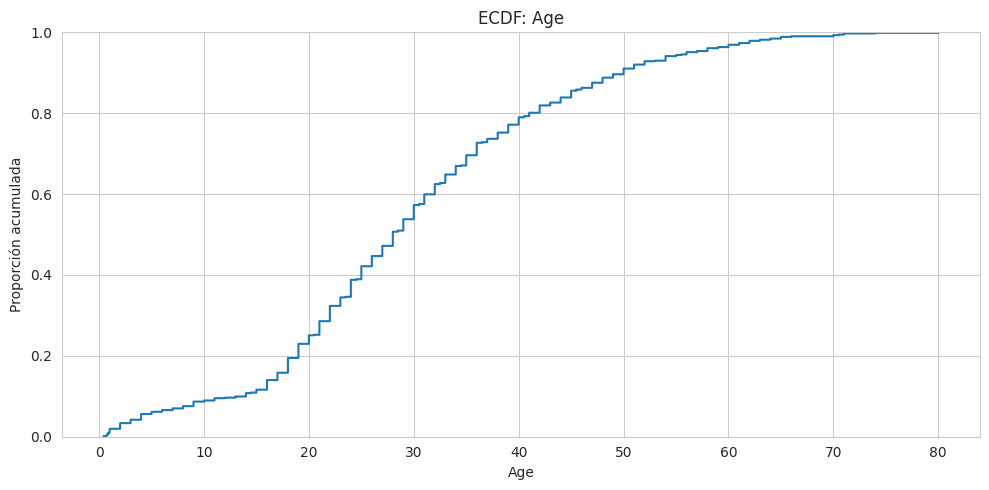

Guardado: exports/figuras/ecdf_Fare.png


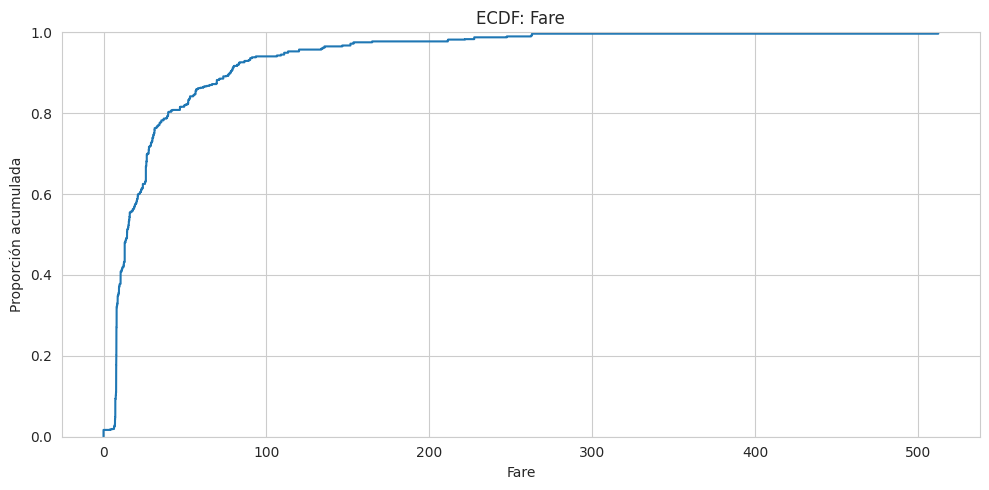

In [21]:
# --- 7.2 ECDF (≥2 variables) ---
print("=== ECDF ===")
for c in ['Age', 'Fare']:
    plt.figure(figsize=(10, 5))
    sns.ecdfplot(data=df, x=c)
    plt.title(f"ECDF: {c}")
    plt.xlabel(c)
    plt.ylabel("Proporción acumulada")
    savefig(f"ecdf_{c}.png")
    plt.show()

=== Boxplots por grupo ===


/tmp/ipykernel_552202/1153456786.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Sex", y="Age", palette="Set2")


Guardado: exports/figuras/box_Age_by_Sex.png


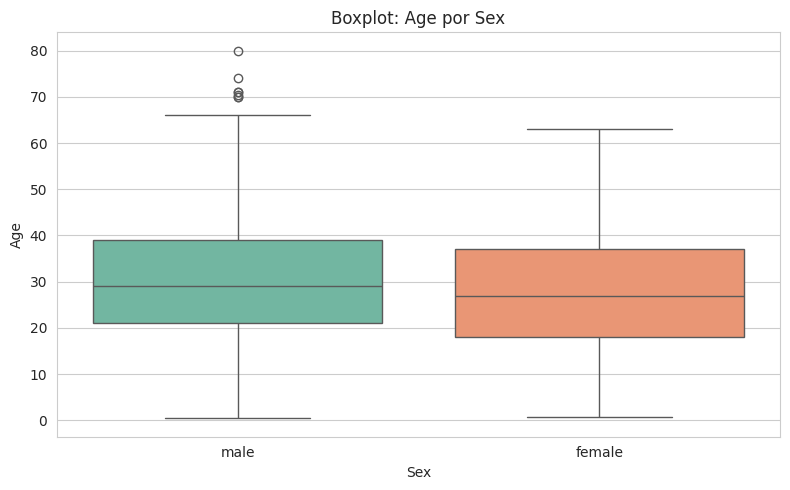

/tmp/ipykernel_552202/1153456786.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Pclass", y="Fare", palette="Set2")


Guardado: exports/figuras/box_Fare_by_Pclass.png


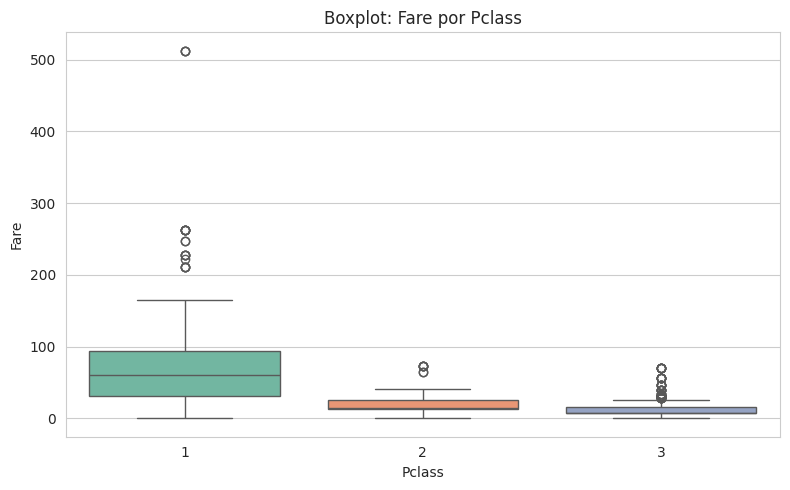

/tmp/ipykernel_552202/1153456786.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Survived", y="Age", palette="Set2")


Guardado: exports/figuras/box_Age_by_Survived.png


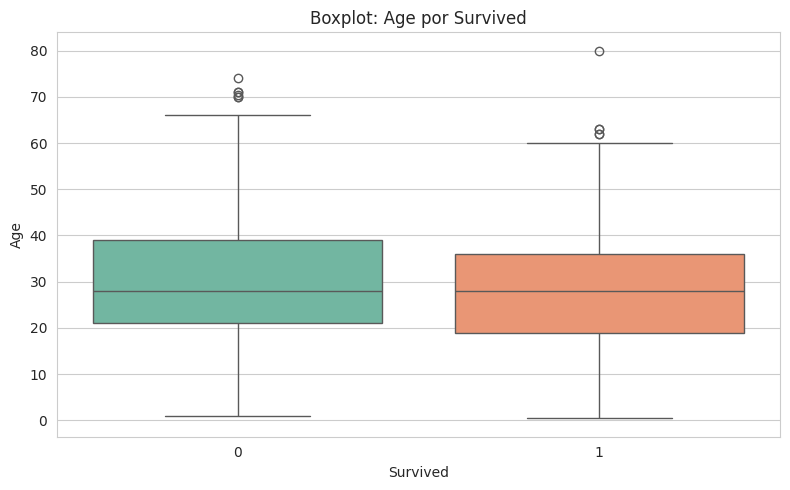

In [22]:
# --- 7.3 Boxplot por grupos ---
print("=== Boxplots por grupo ===")
# Age por Sex
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Sex", y="Age", palette="Set2")
plt.title("Boxplot: Age por Sex")
savefig("box_Age_by_Sex.png")
plt.show()

# Fare por Pclass
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Pclass", y="Fare", palette="Set2")
plt.title("Boxplot: Fare por Pclass")
savefig("box_Fare_by_Pclass.png")
plt.show()

# Age por Survived
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x="Survived", y="Age", palette="Set2")
plt.title("Boxplot: Age por Survived")
savefig("box_Age_by_Survived.png")
plt.show()

=== Violin plots ===


/tmp/ipykernel_552202/1877790963.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Sex", y="Age", palette="muted", cut=0)


Guardado: exports/figuras/violin_Age_by_Sex.png


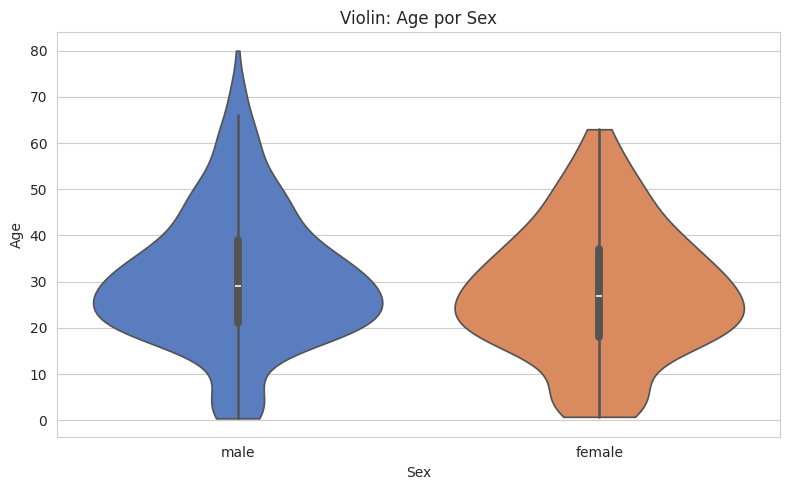

/tmp/ipykernel_552202/1877790963.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Pclass", y="Fare", palette="muted", cut=0)


Guardado: exports/figuras/violin_Fare_by_Pclass.png


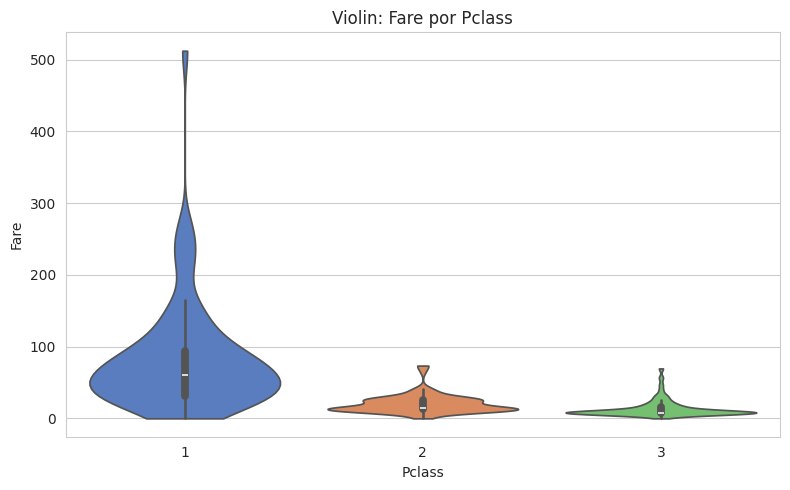

Guardado: exports/figuras/violin_Age_Survived_Sex.png


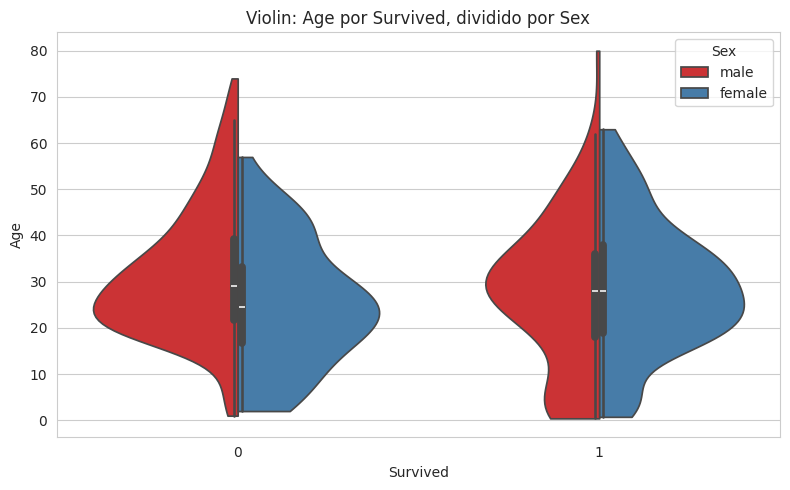

In [23]:
# --- 7.4 Violin plots por grupos ---
print("=== Violin plots ===")
# Age por Sex
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x="Sex", y="Age", palette="muted", cut=0)
plt.title("Violin: Age por Sex")
savefig("violin_Age_by_Sex.png")
plt.show()

# Fare por Pclass
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x="Pclass", y="Fare", palette="muted", cut=0)
plt.title("Violin: Fare por Pclass")
savefig("violin_Fare_by_Pclass.png")
plt.show()

# Age por Survived
plt.figure(figsize=(8, 5))
sns.violinplot(data=df, x="Survived", y="Age", hue="Sex", split=True, palette="Set1", cut=0)
plt.title("Violin: Age por Survived, dividido por Sex")
savefig("violin_Age_Survived_Sex.png")
plt.show()

=== Scatter plots ===


Guardado: exports/figuras/scatter_Age_vs_Fare.png


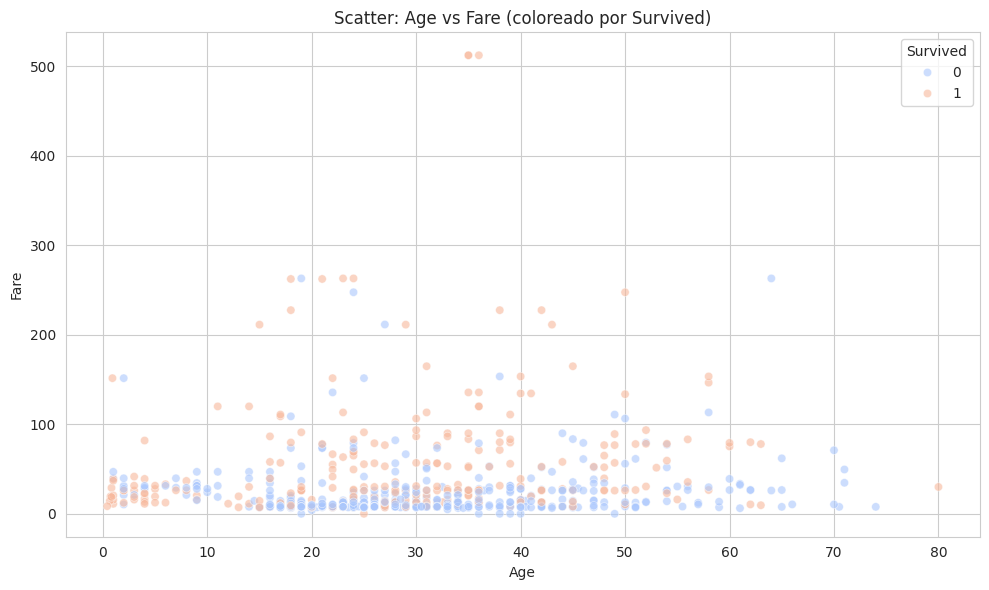

Guardado: exports/figuras/scatter_Age_vs_SibSp.png


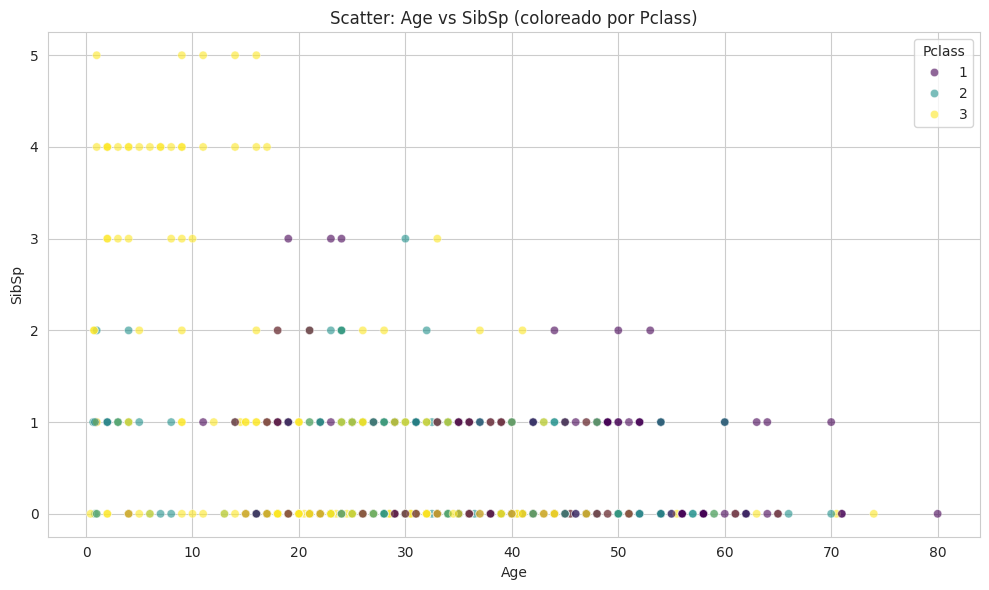

Guardado: exports/figuras/scatter_Fare_vs_Parch.png


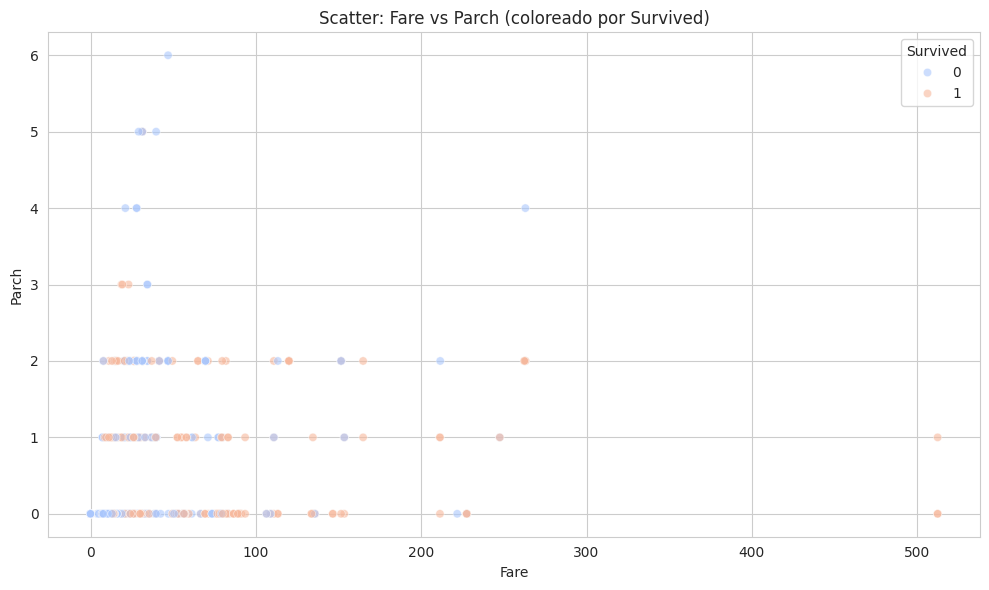

In [24]:
# --- 7.5 Scatter plots (≥3 pares) ---
print("=== Scatter plots ===")

# Age vs Fare (coloreado por Survived)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Age", y="Fare", hue="Survived", alpha=0.6, palette="coolwarm")
plt.title("Scatter: Age vs Fare (coloreado por Survived)")
savefig("scatter_Age_vs_Fare.png")
plt.show()

# Age vs SibSp
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Age", y="SibSp", hue="Pclass", alpha=0.6, palette="viridis")
plt.title("Scatter: Age vs SibSp (coloreado por Pclass)")
savefig("scatter_Age_vs_SibSp.png")
plt.show()

# Fare vs Parch
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="Fare", y="Parch", hue="Survived", alpha=0.6, palette="coolwarm")
plt.title("Scatter: Fare vs Parch (coloreado por Survived)")
savefig("scatter_Fare_vs_Parch.png")
plt.show()

=== Pairplot ===


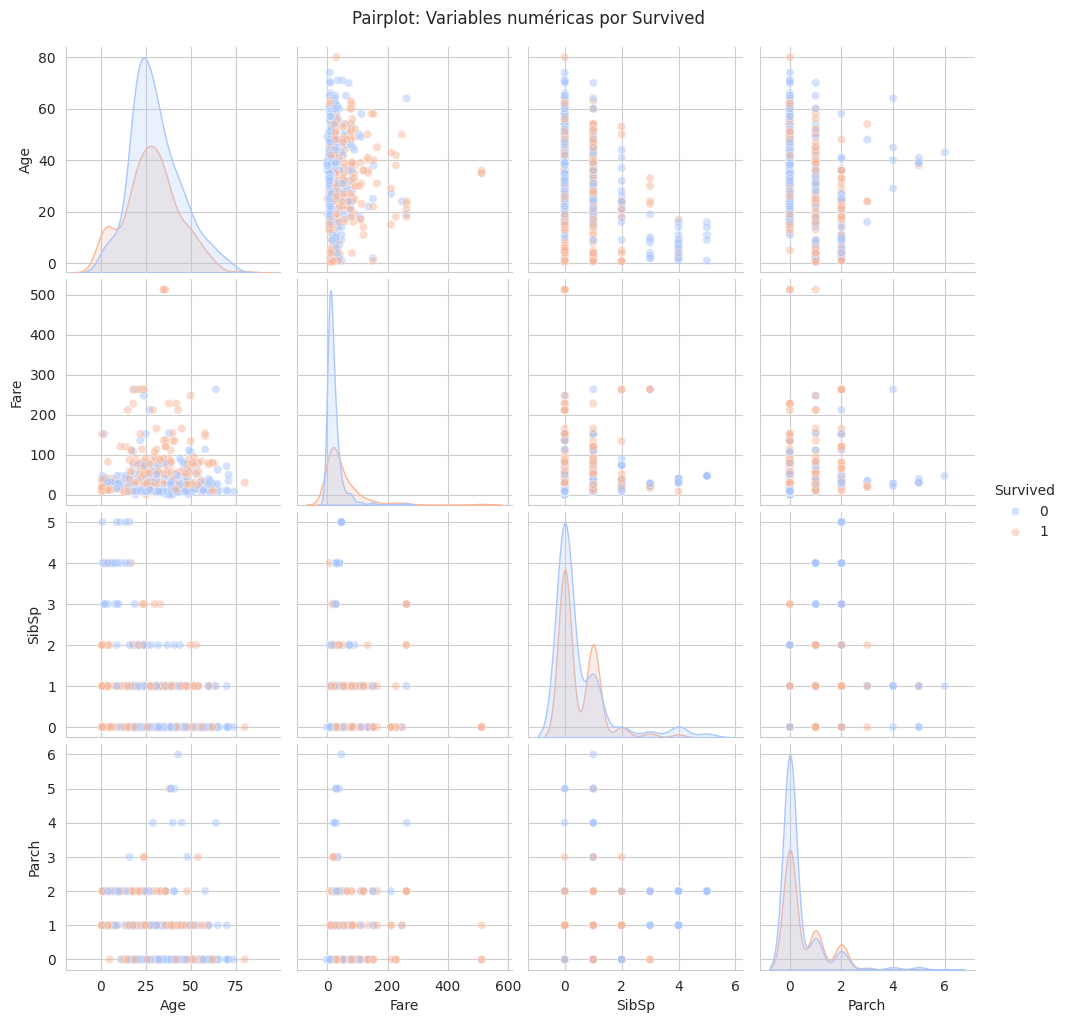

In [25]:
# --- 7.6 Pairplot (subset) ---
print("=== Pairplot ===")
subset_cols = ['Age', 'Fare', 'SibSp', 'Parch', 'Survived']
g = sns.pairplot(df[subset_cols].dropna(), hue="Survived", palette="coolwarm",
                 diag_kind="kde", plot_kws={"alpha": 0.5})
g.fig.suptitle("Pairplot: Variables numéricas por Survived", y=1.02)
g.savefig(os.path.join("exports", "figuras", "pairplot_subset.png"), dpi=160, bbox_inches="tight")
plt.show()

=== Heatmap de correlación ===


Guardado: exports/figuras/heatmap_correlacion.png


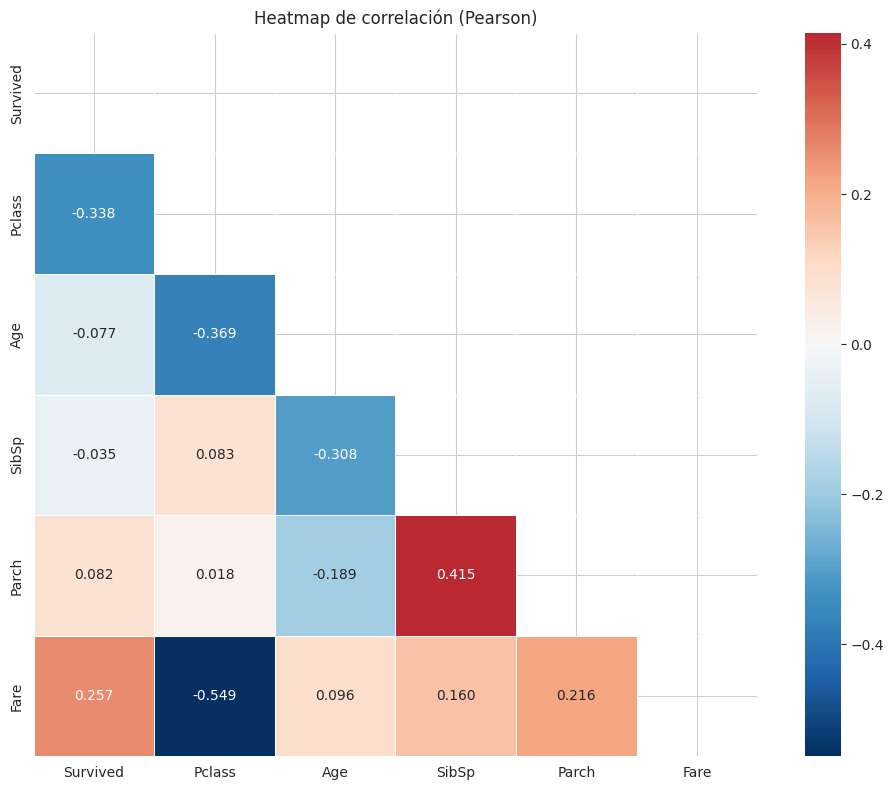

In [26]:
# --- 7.7 Heatmap de correlación ---
print("=== Heatmap de correlación ===")
corr_cols = ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
corr = df[corr_cols].corr()
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))  # Máscara triangular
sns.heatmap(corr, annot=True, fmt=".3f", cmap="RdBu_r", center=0,
            mask=mask, square=True, linewidths=0.5)
plt.title("Heatmap de correlación (Pearson)")
savefig("heatmap_correlacion.png")
plt.show()

=== Jointplot ===


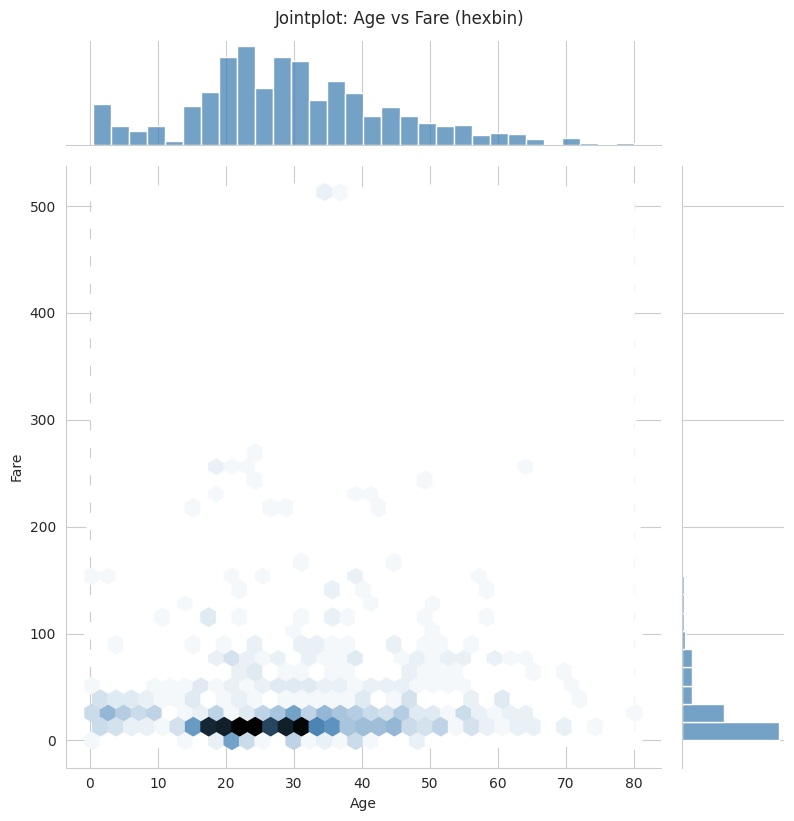

In [27]:
# --- 7.8 Visualización avanzada 1: Jointplot ---
print("=== Jointplot ===")
jp = sns.jointplot(data=df, x="Age", y="Fare", kind="hex", height=8,
                   color="steelblue", marginal_kws={"bins": 30})
jp.fig.suptitle("Jointplot: Age vs Fare (hexbin)", y=1.02)
jp.fig.savefig(os.path.join("exports", "figuras", "jointplot_Age_vs_Fare.png"),
               dpi=160, bbox_inches="tight")
plt.show()

=== FacetGrid: Distribución de Age por Pclass y Survived ===


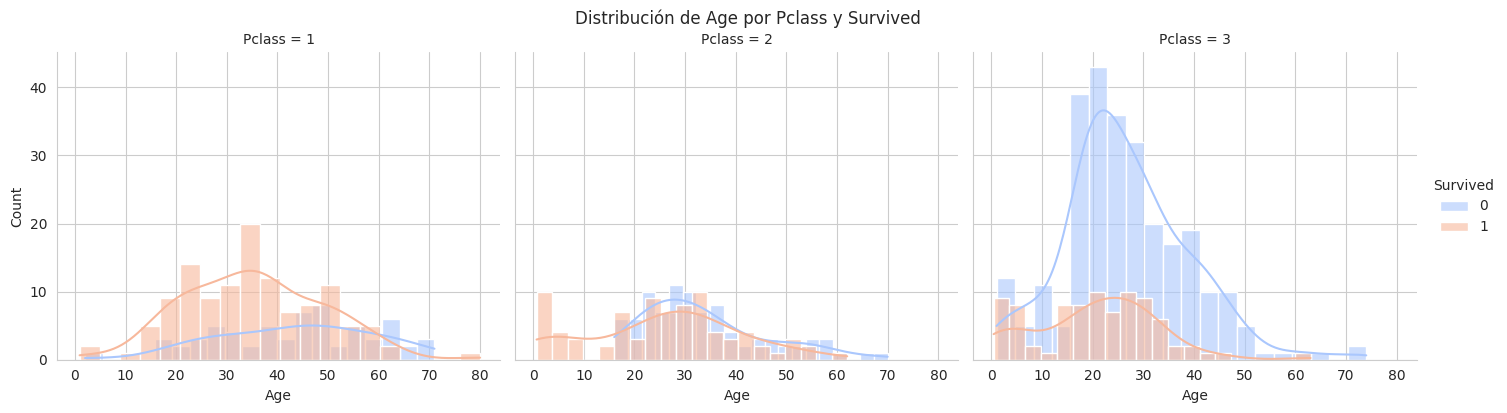

In [28]:
# --- 7.9 Visualización avanzada 2: FacetGrid ---
print("=== FacetGrid: Distribución de Age por Pclass y Survived ===")
g = sns.FacetGrid(df.dropna(subset=["Age"]), col="Pclass", hue="Survived",
                  palette="coolwarm", height=4, aspect=1.2)
g.map(sns.histplot, "Age", kde=True, bins=20, alpha=0.6)
g.add_legend(title="Survived")
g.fig.suptitle("Distribución de Age por Pclass y Survived", y=1.02)
g.savefig(os.path.join("exports", "figuras", "facetgrid_age_pclass_survived.png"),
          dpi=160, bbox_inches="tight")
plt.show()

=== Countplots de supervivencia ===


Guardado: exports/figuras/countplot_supervivencia.png


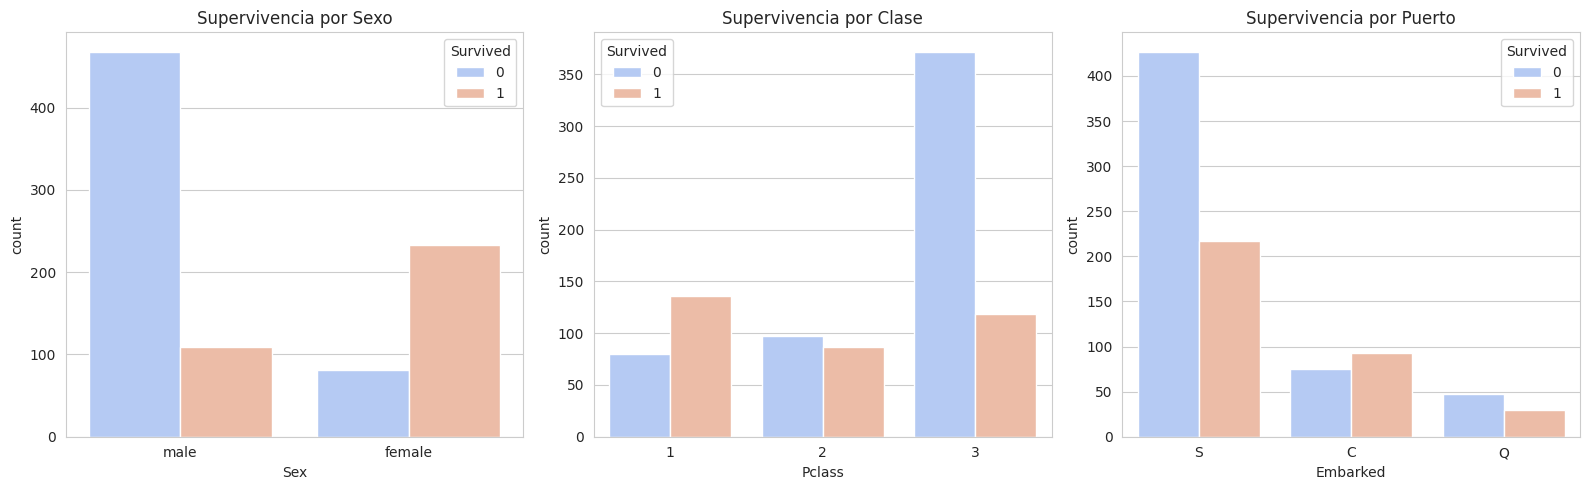

In [29]:
# --- 7.10 Visualización avanzada 3: Countplot de supervivencia ---
print("=== Countplots de supervivencia ===")
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Por Sex
sns.countplot(data=df, x="Sex", hue="Survived", palette="coolwarm", ax=axes[0])
axes[0].set_title("Supervivencia por Sexo")

# Por Pclass
sns.countplot(data=df, x="Pclass", hue="Survived", palette="coolwarm", ax=axes[1])
axes[1].set_title("Supervivencia por Clase")

# Por Embarked
sns.countplot(data=df, x="Embarked", hue="Survived", palette="coolwarm", ax=axes[2])
axes[2].set_title("Supervivencia por Puerto")

plt.tight_layout()
savefig("countplot_supervivencia.png")
plt.show()

=== Heatmap de tasa de supervivencia ===


Guardado: exports/figuras/heatmap_supervivencia_sex_pclass.png


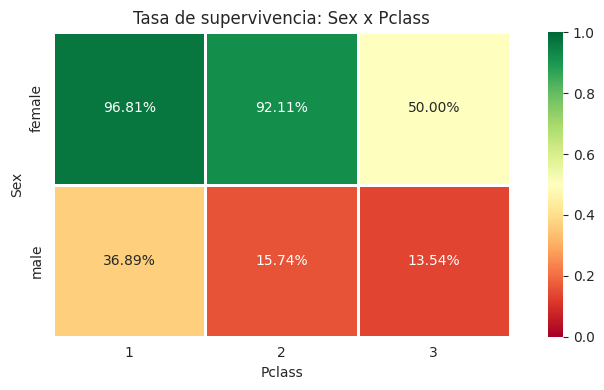

In [30]:
# --- 7.11 Visualización avanzada 4: Heatmap supervivencia Sex x Pclass ---
print("=== Heatmap de tasa de supervivencia ===")
pivot_surv = df.pivot_table(values="Survived", index="Sex", columns="Pclass", aggfunc="mean")
plt.figure(figsize=(8, 4))
sns.heatmap(pivot_surv, annot=True, fmt=".2%", cmap="RdYlGn", vmin=0, vmax=1,
            linewidths=1, square=True)
plt.title("Tasa de supervivencia: Sex x Pclass")
savefig("heatmap_supervivencia_sex_pclass.png")
plt.show()

**Conclusión Sección 7:**
- **Hist/KDE:** Age tiene distribución relativamente normal con un pico en 20-30 años. Fare está fuertemente sesgada a la derecha con outliers extremos.
- **Boxplots:** Fare por Pclass muestra clara diferencia entre clases; 1ra clase tiene tarifas mucho más altas y dispersas.
- **Violin (dividido):** Las mujeres sobrevivientes se distribuyeron uniformemente en edad, mientras que los hombres sobrevivientes tienden a ser más jóvenes.
- **Scatter:** No hay correlación lineal fuerte entre Age y Fare, pero se observan patrones de supervivencia.
- **Correlación:** La correlación más fuerte con Survived es Pclass (-0.34) y Fare (0.26). Pclass y Fare están inversamente correlacionados (-0.55).
- **FacetGrid:** En 3ra clase la mortalidad fue alta para todas las edades. En 1ra clase hubo alta supervivencia especialmente en mujeres.
- **Decisión:** Las visualizaciones confirman que Sex, Pclass y Fare son las variables más discriminantes para predecir supervivencia.

## 8) Outliers: univariados y multivariados

In [31]:
# ============================================================
# 8) Outliers
# ============================================================

def iqr_fences(x: pd.Series, k=1.5):
    q1, q3 = x.quantile(0.25), x.quantile(0.75)
    iqr = q3 - q1
    return q1 - k*iqr, q3 + k*iqr, iqr

def modified_zscore_mad(x: pd.Series):
    x = x.dropna()
    med = x.median()
    mad = np.median(np.abs(x - med))
    if mad == 0:
        return pd.Series(np.zeros(len(x)), index=x.index)
    return 0.6745 * (x - med) / mad

# Usamos variables significativas (NO PassengerId)
CANDIDATAS = ['Age', 'Fare', 'SibSp', 'Parch']
OUTLIER_RES = {}

for c in CANDIDATAS:
    x = df[c].dropna()
    if x.empty:
        continue

    lo15, hi15, _ = iqr_fences(x, k=1.5)
    lo30, hi30, _ = iqr_fences(x, k=3.0)
    idx_iqr15 = x[(x < lo15) | (x > hi15)].index
    idx_iqr30 = x[(x < lo30) | (x > hi30)].index

    z = (x - x.mean()) / x.std(ddof=1) if x.std(ddof=1) != 0 else pd.Series(np.zeros(len(x)), index=x.index)
    idx_z3 = z[abs(z) > 3].index

    mz = modified_zscore_mad(x)
    idx_mz35 = mz[abs(mz) > 3.5].index

    OUTLIER_RES[c] = {
        "iqr_1.5": len(idx_iqr15),
        "iqr_3.0": len(idx_iqr30),
        "z_gt_3": len(idx_z3),
        "modz_gt_3.5": len(idx_mz35)
    }

print("=== Detección de outliers univariados ===")
outlier_df = pd.DataFrame(OUTLIER_RES).T
outlier_df = outlier_df.sort_values("iqr_1.5", ascending=False)
display(outlier_df)

=== Detección de outliers univariados ===


,iqr_1.5,iqr_3.0,z_gt_3,modz_gt_3.5
Parch,213,213,15,0
Fare,116,53,20,160
SibSp,46,12,30,0
Age,11,0,2,1


In [32]:
# Visualizar outliers de Fare (variable con más outliers)
print("=== Outliers de Fare ===")
x_fare = df['Fare'].dropna()
lo15, hi15, iqr_val = iqr_fences(x_fare, k=1.5)
lo30, hi30, _ = iqr_fences(x_fare, k=3.0)

print(f"IQR: {iqr_val:.2f}")
print(f"Cercas 1.5*IQR: [{lo15:.2f}, {hi15:.2f}]")
print(f"Cercas 3.0*IQR: [{lo30:.2f}, {hi30:.2f}]")
print(f"\nOutliers extremos (Fare > {hi30:.2f}):")
display(df[df['Fare'] > hi30][['PassengerId', 'Name', 'Pclass', 'Fare', 'Survived']].head(10))

=== Outliers de Fare ===
IQR: 23.09
Cercas 1.5*IQR: [-26.72, 65.63]
Cercas 3.0*IQR: [-61.36, 100.27]

Outliers extremos (Fare > 100.27):


,PassengerId,Name,Pclass,Fare,Survived
27,28,"Fortune, Mr. Charles Alexander",1,263.0000,0
31,32,"Spencer, Mrs. William Augustus (Marie Eugenie)",1,146.5208,1
88,89,"Fortune, Miss. Mabel Helen",1,263.0000,1
118,119,"Baxter, Mr. Quigg Edmond",1,247.5208,0
195,196,"Lurette, Miss. Elise",1,146.5208,1
215,216,"Newell, Miss. Madeleine",1,113.2750,1
258,259,"Ward, Miss. Anna",1,512.3292,1
268,269,"Graham, Mrs. William Thompson (Edith Junkins)",1,153.4625,1
269,270,"Bissette, Miss. Amelia",1,135.6333,1
297,298,"Allison, Miss. Helen Loraine",1,151.5500,0


In [33]:
# --- Outliers multivariados ---
print("=== Detección de outliers multivariados ===")

# Usamos solo variables numéricas relevantes
X = df[['Age', 'Fare', 'SibSp', 'Parch', 'Pclass']].copy()
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median(numeric_only=True))

pt = PowerTransformer(method="yeo-johnson", standardize=True)
X_t = pt.fit_transform(X)

# DBSCAN
db = DBSCAN(eps=1.8, min_samples=10)
labels = db.fit_predict(X_t)
idx_dbscan_noise = np.where(labels == -1)[0]

# Isolation Forest
iso = IsolationForest(n_estimators=300, contamination="auto", random_state=42)
pred_iso = iso.fit_predict(X_t)
idx_iso = np.where(pred_iso == -1)[0]

# LOF
lof = LocalOutlierFactor(n_neighbors=25, contamination="auto")
pred_lof = lof.fit_predict(X_t)
idx_lof = np.where(pred_lof == -1)[0]

print(f"DBSCAN (noise): {len(idx_dbscan_noise)} outliers")
print(f"IsolationForest: {len(idx_iso)} outliers")
print(f"LOF: {len(idx_lof)} outliers")

# Sistema de votación
flags = pd.DataFrame({"dbscan_noise": 0, "iso_outlier": 0, "lof_outlier": 0}, index=df.index)
flags.iloc[idx_dbscan_noise, 0] = 1
flags.iloc[idx_iso, 1] = 1
flags.iloc[idx_lof, 2] = 1
flags["votes"] = flags.sum(axis=1)

print("\n=== Sistema de votación (# métodos que detectan outlier) ===")
display(flags["votes"].value_counts().sort_index(ascending=False))

print("\n=== Top 15 outliers multivariados (detectados por 2+ métodos) ===")
top_outliers = flags[flags["votes"] >= 2].sort_values("votes", ascending=False)
display(df.loc[top_outliers.head(15).index, ['PassengerId', 'Name', 'Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch']])

=== Detección de outliers multivariados ===


DBSCAN (noise): 0 outliers
IsolationForest: 389 outliers
LOF: 126 outliers

=== Sistema de votación (# métodos que detectan outlier) ===


votes
2     49
1    417
0    425
Name: count, dtype: int64


=== Top 15 outliers multivariados (detectados por 2+ métodos) ===


,PassengerId,Name,Pclass,Sex,Age,Fare,SibSp,Parch
40,41,"Ahlin, Mrs. Johan (Johanna Persdotter Larsson)",3,female,40.0,9.4750,1,0
74,75,"Bing, Mr. Lee",3,male,32.0,56.4958,0,0
94,95,"Coxon, Mr. Daniel",3,male,59.0,7.2500,0,0
104,105,"Gustafsson, Mr. Anders Vilhelm",3,male,37.0,7.9250,2,0
116,117,"Connors, Mr. Patrick",3,male,70.5,7.7500,0,0
132,133,"Robins, Mrs. Alexander A (Grace Charity Laury)",3,female,47.0,14.5000,1,0
169,170,"Ling, Mr. Lee",3,male,28.0,56.4958,0,0
179,180,"Leonard, Mr. Lionel",3,male,36.0,0.0000,0,0
183,184,"Becker, Master. Richard F",2,male,1.0,39.0000,2,1
193,194,"Navratil, Master. Michel M",2,male,3.0,26.0000,1,1


**Conclusión Sección 8:**
- **Fare** es la variable con más outliers (116 por IQR 1.5x). Los valores extremos (>300 libras) corresponden a pasajeros de 1ra clase en suites de lujo — son **casos raros válidos**, no errores.
- **SibSp y Parch** tienen outliers por familias grandes: son **eventos reales** (familias numerosas que viajaban juntas).
- **Age** tiene pocos outliers. El valor máximo (80 años) es válido.
- **Multivariado:** Los outliers consensuados (2+ métodos) son principalmente pasajeros con familias muy grandes y tarifas extremas.
- **Decisión:** No eliminar outliers porque representan eventos reales. Para modelado, se recomienda winsorizar Fare y transformar con log.

## 9) Tratamiento de outliers (antes vs. después)

In [34]:
# ============================================================
# 9) Tratamiento de outliers — Variable: Fare
# ============================================================
# Se elige Fare por ser la variable con mayor asimetría (skew=4.79) y más outliers

VAR_TRATAR = "Fare"
x0 = df[VAR_TRATAR].copy()

# Tratamiento 1: Winsorización al 1%
x_w = pd.Series(winsorize(x0, limits=[0.01, 0.01]), index=x0.index)

# Tratamiento 2: Transformación log1p (Fare >= 0)
x_log = np.log1p(x0)

# Tratamiento 3: Transformación Yeo-Johnson
pt_fare = PowerTransformer(method="yeo-johnson", standardize=True)
x_yj = pd.Series(pt_fare.fit_transform(x0.values.reshape(-1, 1)).flatten(), index=x0.index)

def resumen_simple(s: pd.Series) -> pd.Series:
    s2 = s.dropna()
    return pd.Series({
        "n": int(s2.shape[0]),
        "mean": round(float(s2.mean()), 4),
        "median": round(float(s2.median()), 4),
        "std": round(float(s2.std(ddof=1)), 4),
        "min": round(float(s2.min()), 4),
        "p25": round(float(s2.quantile(0.25)), 4),
        "p75": round(float(s2.quantile(0.75)), 4),
        "max": round(float(s2.max()), 4),
        "skew": round(float(stats.skew(s2, bias=False)), 4) if s2.shape[0] > 2 else np.nan,
        "kurtosis": round(float(stats.kurtosis(s2, bias=False)), 4) if s2.shape[0] > 3 else np.nan,
    })

comparacion = pd.DataFrame({
    "original": resumen_simple(x0),
    "winsor_1pct": resumen_simple(x_w),
    "log1p": resumen_simple(x_log),
    "yeo_johnson": resumen_simple(x_yj)
})

print("=== Comparación antes vs. después del tratamiento ===")
display(comparacion)

=== Comparación antes vs. después del tratamiento ===


/home/santiago/.local/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/santiago/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(
/home/santiago/.local/lib/python3.10/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


,original,winsor_1pct,log1p,yeo_johnson
n,891.0000,891.0000,891.0000,891.0000
mean,32.2042,31.3598,2.9622,0.0000
median,14.4542,14.4542,2.7379,-0.1891
std,49.6934,43.2316,0.9690,1.0006
min,0.0000,0.0000,0.0000,-3.5341
p25,7.9104,7.9104,2.1872,-0.7919
p75,31.0000,31.0000,3.4657,0.5595
max,512.3292,262.3750,6.2409,2.9712
skew,4.7873,3.2062,0.3949,-0.0403
kurtosis,33.3981,11.8610,0.9761,1.5323


Guardado: exports/figuras/tratamiento_comparacion_Fare.png


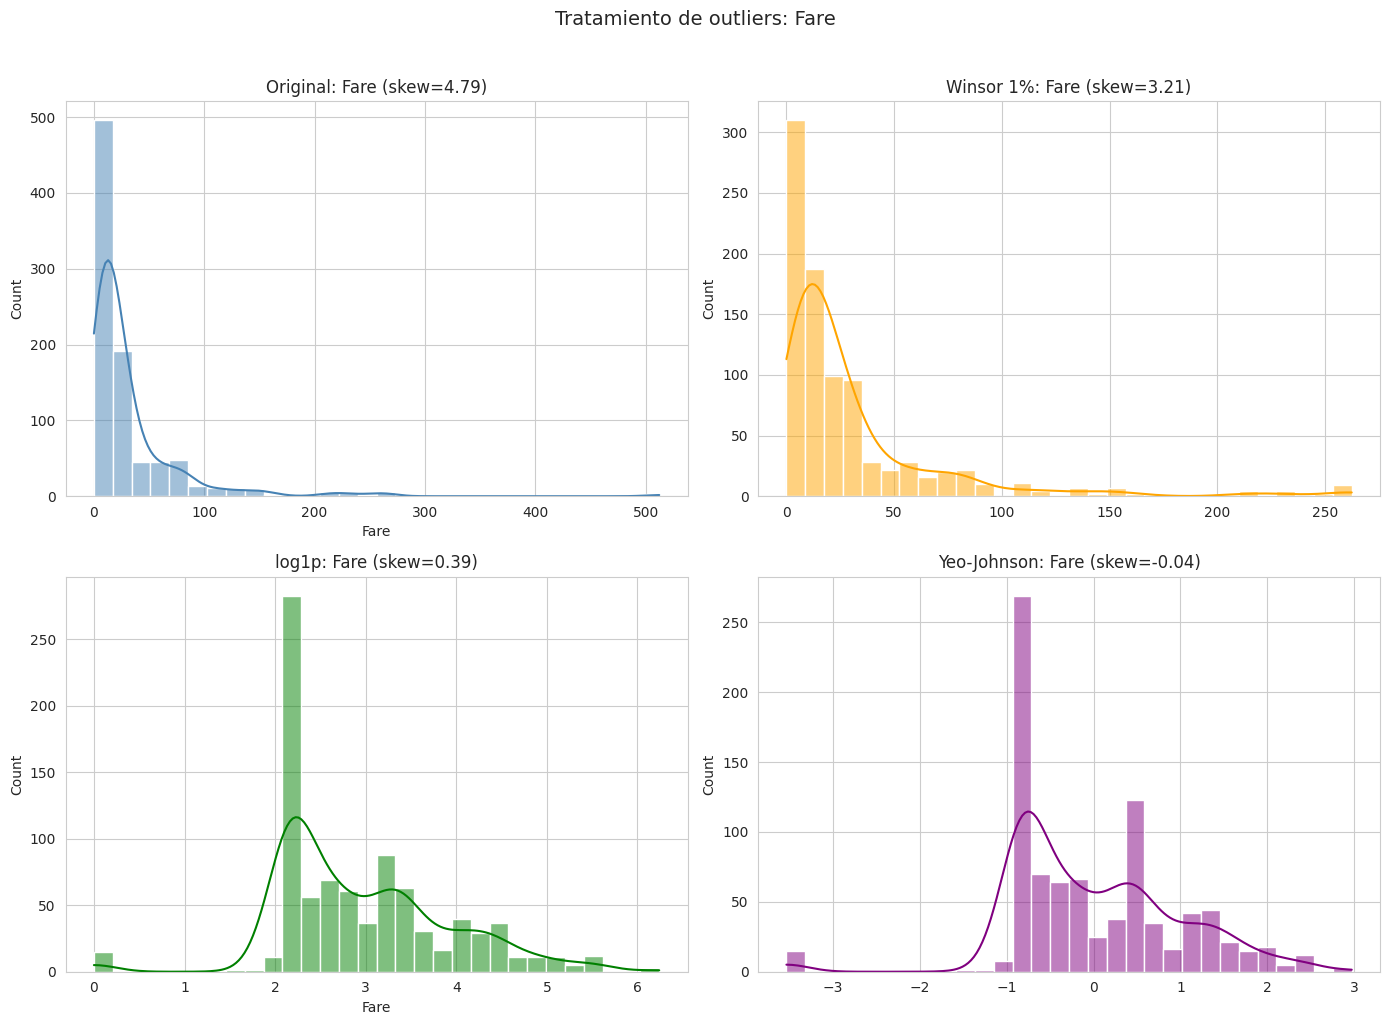

In [35]:
# --- Gráficos comparativos ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original
sns.histplot(x0, kde=True, bins=30, ax=axes[0,0], color="steelblue")
axes[0,0].set_title(f"Original: {VAR_TRATAR} (skew={stats.skew(x0, bias=False):.2f})")

# Winsor
sns.histplot(x_w, kde=True, bins=30, ax=axes[0,1], color="orange")
axes[0,1].set_title(f"Winsor 1%: {VAR_TRATAR} (skew={stats.skew(x_w, bias=False):.2f})")

# Log1p
sns.histplot(x_log, kde=True, bins=30, ax=axes[1,0], color="green")
axes[1,0].set_title(f"log1p: {VAR_TRATAR} (skew={stats.skew(x_log, bias=False):.2f})")

# Yeo-Johnson
sns.histplot(x_yj, kde=True, bins=30, ax=axes[1,1], color="purple")
axes[1,1].set_title(f"Yeo-Johnson: {VAR_TRATAR} (skew={stats.skew(x_yj, bias=False):.2f})")

plt.suptitle(f"Tratamiento de outliers: {VAR_TRATAR}", fontsize=14, y=1.02)
plt.tight_layout()
savefig(f"tratamiento_comparacion_{VAR_TRATAR}.png")
plt.show()

Guardado: exports/figuras/boxplot_tratamiento_Fare.png


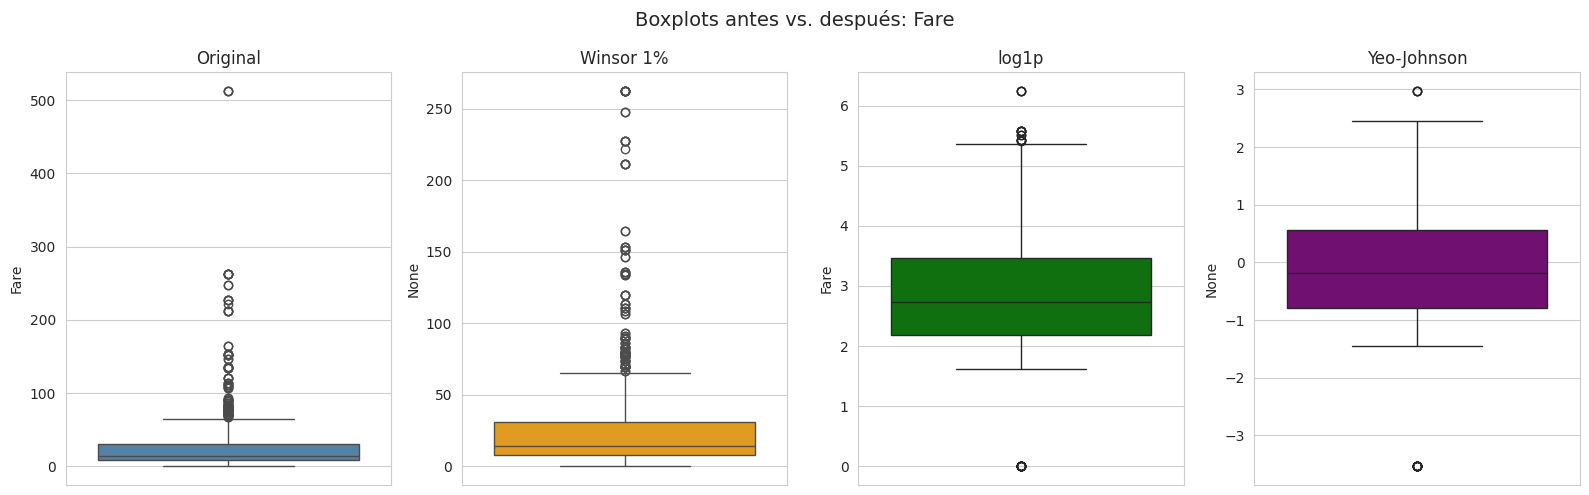

In [36]:
# --- Boxplots antes vs. después ---
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

sns.boxplot(y=x0, ax=axes[0], color="steelblue")
axes[0].set_title("Original")

sns.boxplot(y=x_w, ax=axes[1], color="orange")
axes[1].set_title("Winsor 1%")

sns.boxplot(y=x_log, ax=axes[2], color="green")
axes[2].set_title("log1p")

sns.boxplot(y=x_yj, ax=axes[3], color="purple")
axes[3].set_title("Yeo-Johnson")

plt.suptitle(f"Boxplots antes vs. después: {VAR_TRATAR}", fontsize=14)
plt.tight_layout()
savefig(f"boxplot_tratamiento_{VAR_TRATAR}.png")
plt.show()

**Conclusión Sección 9:**
- **Original:** Fare tiene skewness=4.79 y kurtosis=33.40 — distribución muy asimétrica.
- **Winsorización 1%:** Reduce el skewness moderadamente al recortar los extremos, preservando la escala original. Útil cuando se necesita interpretar los valores en la escala original.
- **log1p:** Reduce drásticamente el skewness, acercando la distribución a la normalidad. Ideal para modelos que asumen normalidad.
- **Yeo-Johnson:** El mejor resultado en términos de simetría (skew ≈ 0), pero pierde interpretabilidad.
- **Decisión:** Para análisis descriptivo usar Winsorización. Para modelado predictivo usar log1p por su buen balance entre normalización e interpretabilidad.

## 10) Inferencia estadística mínima

In [37]:
# ============================================================
# 10) Inferencia estadística
# ============================================================
ALPHA = 0.05

# --- 10.1 Prueba de normalidad: Shapiro-Wilk sobre Age ---
print("=" * 60)
print("10.1 PRUEBA DE NORMALIDAD — Shapiro-Wilk")
print("=" * 60)

var_norm = "Age"
x = df[var_norm].dropna()
x_sample = x.sample(min(len(x), 5000), random_state=42)

W, p = stats.shapiro(x_sample)
print(f"Variable: {var_norm}")
print(f"H0: La variable {var_norm} sigue una distribución normal")
print(f"H1: La variable {var_norm} NO sigue una distribución normal")
print(f"α = {ALPHA}")
print(f"Resultado: W = {W:.4f}, p-value = {p:.6f}")
print(f"Conclusión: {'Rechazamos H0 — Age NO es normal (p < α)' if p < ALPHA else 'No rechazamos H0 — Age es compatible con normalidad'}")

# También para Fare
var_norm2 = "Fare"
x2 = df[var_norm2].dropna()
W2, p2 = stats.shapiro(x2.sample(min(len(x2), 5000), random_state=42))
print(f"\nShapiro-Wilk sobre Fare: W={W2:.4f}, p={p2:.6f}")
print(f"Conclusión: {'Rechazamos H0 — Fare NO es normal' if p2 < ALPHA else 'No rechazamos H0'}")

10.1 PRUEBA DE NORMALIDAD — Shapiro-Wilk
Variable: Age
H0: La variable Age sigue una distribución normal
H1: La variable Age NO sigue una distribución normal
α = 0.05
Resultado: W = 0.9815, p-value = 0.000000
Conclusión: Rechazamos H0 — Age NO es normal (p < α)

Shapiro-Wilk sobre Fare: W=0.5219, p=0.000000
Conclusión: Rechazamos H0 — Fare NO es normal


Guardado: exports/figuras/qqplot_age_fare.png


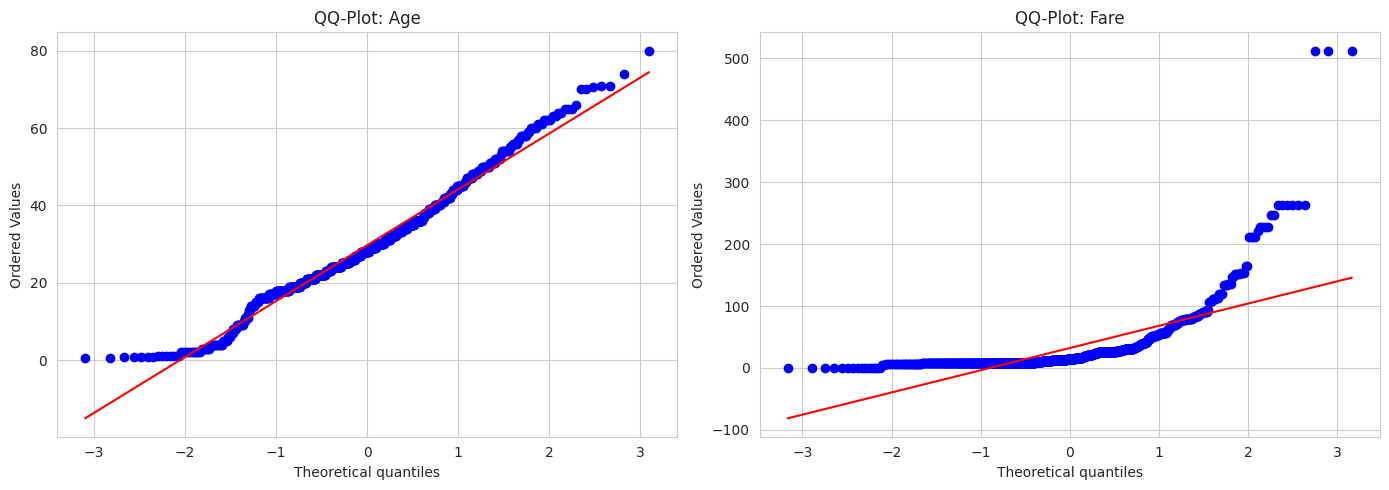

In [38]:
# QQ-plots para verificar visualmente normalidad
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

stats.probplot(df['Age'].dropna(), dist="norm", plot=axes[0])
axes[0].set_title("QQ-Plot: Age")

stats.probplot(df['Fare'].dropna(), dist="norm", plot=axes[1])
axes[1].set_title("QQ-Plot: Fare")

plt.tight_layout()
savefig("qqplot_age_fare.png")
plt.show()

In [39]:
# --- 10.2 t-test (Welch) — Comparar Fare entre sobrevivientes y no sobrevivientes ---
print("=" * 60)
print("10.2 T-TEST DE WELCH — Fare por Survived")
print("=" * 60)

grupo_a = df.loc[df["Survived"] == 1, "Fare"].dropna()
grupo_b = df.loc[df["Survived"] == 0, "Fare"].dropna()

print(f"H0: No hay diferencia significativa en Fare entre sobrevivientes y no sobrevivientes")
print(f"H1: Hay diferencia significativa en Fare entre ambos grupos")
print(f"α = {ALPHA}")
print(f"\nSobrevivientes (n={len(grupo_a)}): media={grupo_a.mean():.2f}, mediana={grupo_a.median():.2f}")
print(f"No sobrevivientes (n={len(grupo_b)}): media={grupo_b.mean():.2f}, mediana={grupo_b.median():.2f}")

t_stat, p_ttest = stats.ttest_ind(grupo_a, grupo_b, equal_var=False)
print(f"\nResultado: t = {t_stat:.4f}, p-value = {p_ttest:.6f}")
print(f"Conclusión: {'Rechazamos H0 — Hay diferencia significativa en Fare' if p_ttest < ALPHA else 'No rechazamos H0'}")
print(f"Interpretación: Los sobrevivientes pagaron tarifas significativamente más altas (media ${grupo_a.mean():.2f} vs ${grupo_b.mean():.2f}).")
print(f"Esto se explica porque los pasajeros de 1ra clase (tarifas altas) tuvieron mayor tasa de supervivencia.")

10.2 T-TEST DE WELCH — Fare por Survived
H0: No hay diferencia significativa en Fare entre sobrevivientes y no sobrevivientes
H1: Hay diferencia significativa en Fare entre ambos grupos
α = 0.05

Sobrevivientes (n=342): media=48.40, mediana=26.00
No sobrevivientes (n=549): media=22.12, mediana=10.50

Resultado: t = 6.8391, p-value = 0.000000
Conclusión: Rechazamos H0 — Hay diferencia significativa en Fare
Interpretación: Los sobrevivientes pagaron tarifas significativamente más altas (media $48.40 vs $22.12).
Esto se explica porque los pasajeros de 1ra clase (tarifas altas) tuvieron mayor tasa de supervivencia.


In [40]:
# --- 10.3 ANOVA — Comparar Age entre las 3 clases (Pclass) ---
print("=" * 60)
print("10.3 ANOVA — Age por Pclass (3 grupos)")
print("=" * 60)

d_anova = df[["Pclass", "Age"]].dropna().copy()
d_anova["Pclass"] = d_anova["Pclass"].astype("category")

print(f"H0: La edad media es igual en las 3 clases (μ1 = μ2 = μ3)")
print(f"H1: Al menos una clase tiene una edad media diferente")
print(f"α = {ALPHA}")

# Estadísticas por grupo
print("\nEstadísticas por grupo:")
for cls in [1, 2, 3]:
    ages = d_anova.loc[d_anova["Pclass"] == cls, "Age"]
    print(f"  Clase {cls}: n={len(ages)}, media={ages.mean():.2f}, std={ages.std():.2f}")

# ANOVA con statsmodels
model = sm.formula.ols("Age ~ C(Pclass)", data=d_anova).fit()
tabla_anova = anova_lm(model, typ=2)
print("\nTabla ANOVA:")
display(tabla_anova)

p_anova = tabla_anova.loc["C(Pclass)", "PR(>F)"]
print(f"\np-value = {p_anova:.6f}")
print(f"Conclusión: {'Rechazamos H0 — La edad difiere significativamente entre clases' if p_anova < ALPHA else 'No rechazamos H0'}")
print(f"Interpretación: Los pasajeros de 1ra clase eran en promedio mayores que los de 3ra clase,")
print(f"lo cual es consistente con que personas de mayor edad tendían a tener mayor poder adquisitivo.")

10.3 ANOVA — Age por Pclass (3 grupos)
H0: La edad media es igual en las 3 clases (μ1 = μ2 = μ3)
H1: Al menos una clase tiene una edad media diferente
α = 0.05

Estadísticas por grupo:
  Clase 1: n=186, media=38.23, std=14.80
  Clase 2: n=173, media=29.88, std=14.00
  Clase 3: n=355, media=25.14, std=12.50

Tabla ANOVA:


,sum_sq,df,F,PR(>F)
C(Pclass),20929.627754,2.0,57.443484,7.487984e-24
Residual,129527.008190,711.0,NaN,NaN



p-value = 0.000000
Conclusión: Rechazamos H0 — La edad difiere significativamente entre clases
Interpretación: Los pasajeros de 1ra clase eran en promedio mayores que los de 3ra clase,
lo cual es consistente con que personas de mayor edad tendían a tener mayor poder adquisitivo.


In [41]:
# --- 10.4 Correlación Pearson y Spearman — Age vs Fare ---
print("=" * 60)
print("10.4 CORRELACIÓN — Age vs Fare")
print("=" * 60)

df_corr = df[["Age", "Fare"]].dropna()

print(f"H0: No hay correlación lineal significativa entre Age y Fare (ρ = 0)")
print(f"H1: Existe correlación lineal significativa entre Age y Fare (ρ ≠ 0)")
print(f"α = {ALPHA}")

# Pearson
r_pearson, p_pearson = stats.pearsonr(df_corr["Age"], df_corr["Fare"])
print(f"\nPearson: r = {r_pearson:.4f}, p-value = {p_pearson:.6f}")
print(f"Conclusión Pearson: {'Rechazamos H0 — Correlación significativa' if p_pearson < ALPHA else 'No rechazamos H0 — No hay correlación lineal significativa'}")

# Spearman (no asume normalidad)
r_spearman, p_spearman = stats.spearmanr(df_corr["Age"], df_corr["Fare"])
print(f"\nSpearman: ρ = {r_spearman:.4f}, p-value = {p_spearman:.6f}")
print(f"Conclusión Spearman: {'Rechazamos H0 — Correlación monótona significativa' if p_spearman < ALPHA else 'No rechazamos H0'}")

print(f"\nInterpretación: La correlación entre Age y Fare es débil (r≈{r_pearson:.2f}).")
print(f"Aunque estadísticamente significativa (muestra grande), el tamaño del efecto es pequeño.")
print(f"La tarifa está más determinada por la clase del boleto que por la edad del pasajero.")

10.4 CORRELACIÓN — Age vs Fare
H0: No hay correlación lineal significativa entre Age y Fare (ρ = 0)
H1: Existe correlación lineal significativa entre Age y Fare (ρ ≠ 0)
α = 0.05

Pearson: r = 0.0961, p-value = 0.010216
Conclusión Pearson: Rechazamos H0 — Correlación significativa

Spearman: ρ = 0.1351, p-value = 0.000296
Conclusión Spearman: Rechazamos H0 — Correlación monótona significativa

Interpretación: La correlación entre Age y Fare es débil (r≈0.10).
Aunque estadísticamente significativa (muestra grande), el tamaño del efecto es pequeño.
La tarifa está más determinada por la clase del boleto que por la edad del pasajero.


In [42]:
# --- 10.5 Prueba Chi-cuadrado — Relación entre Sex y Survived (extra) ---
print("=" * 60)
print("10.5 CHI-CUADRADO — Sex vs Survived (prueba adicional)")
print("=" * 60)

tabla_contingencia = pd.crosstab(df["Sex"], df["Survived"])
print("Tabla de contingencia:")
display(tabla_contingencia)

chi2, p_chi, dof, expected = stats.chi2_contingency(tabla_contingencia)
print(f"\nH0: Sex y Survived son independientes")
print(f"H1: Existe asociación entre Sex y Survived")
print(f"α = {ALPHA}")
print(f"\nχ² = {chi2:.4f}, p-value = {p_chi:.10f}, grados de libertad = {dof}")
print(f"Conclusión: {'Rechazamos H0 — Existe asociación significativa entre Sex y Survived' if p_chi < ALPHA else 'No rechazamos H0'}")

# Coeficiente de Cramér V
n = tabla_contingencia.sum().sum()
cramers_v = np.sqrt(chi2 / (n * (min(tabla_contingencia.shape) - 1)))
print(f"Cramér's V = {cramers_v:.4f} (fuerza de la asociación: {'fuerte' if cramers_v > 0.3 else 'moderada' if cramers_v > 0.1 else 'débil'})")
print(f"\nInterpretación: El sexo del pasajero está fuertemente asociado con la supervivencia.")
print(f"Las mujeres tuvieron una probabilidad significativamente mayor de sobrevivir que los hombres.")

10.5 CHI-CUADRADO — Sex vs Survived (prueba adicional)
Tabla de contingencia:


Survived,0,1
Sex,,
female,81,233
male,468,109



H0: Sex y Survived son independientes
H1: Existe asociación entre Sex y Survived
α = 0.05

χ² = 260.7170, p-value = 0.0000000000, grados de libertad = 1
Conclusión: Rechazamos H0 — Existe asociación significativa entre Sex y Survived
Cramér's V = 0.5409 (fuerza de la asociación: fuerte)

Interpretación: El sexo del pasajero está fuertemente asociado con la supervivencia.
Las mujeres tuvieron una probabilidad significativamente mayor de sobrevivir que los hombres.


**Conclusión Sección 10:**
- **Normalidad:** Ni Age ni Fare siguen una distribución normal (Shapiro-Wilk p < 0.05). Esto justifica usar pruebas no paramétricas o Welch t-test (robusto a no-normalidad).
- **t-test Welch:** Los sobrevivientes pagaron tarifas significativamente más altas (p < 0.001). Esto se debe a que la clase alta tenía prioridad en los botes salvavidas.
- **ANOVA:** La edad difiere significativamente entre las 3 clases (p < 0.001). Los pasajeros de 1ra clase eran mayores en promedio.
- **Correlación:** La correlación Age-Fare es débil pero significativa. La tarifa depende más de la clase que de la edad.
- **Chi-cuadrado:** Fuerte asociación entre sexo y supervivencia (Cramér's V > 0.5), confirmando la política de "mujeres y niños primero".

## 11) Exportables y cierre

In [43]:
# ============================================================
# 11) Exportables
# ============================================================
os.makedirs("exports", exist_ok=True)
os.makedirs("exports/figuras", exist_ok=True)

# 1) tabla_resumen.csv
desc_export = descriptivo_numerico(df, ['Age', 'Fare', 'SibSp', 'Parch', 'Pclass', 'Survived'])
desc_export.to_csv("exports/tabla_resumen.csv")
print("OK -> exports/tabla_resumen.csv")

# 2) tests.json
tests = {
    "alpha": ALPHA,
    "shapiro_age": {"variable": "Age", "W": float(W), "p": float(p), "normal": bool(p >= ALPHA)},
    "shapiro_fare": {"variable": "Fare", "W": float(W2), "p": float(p2), "normal": bool(p2 >= ALPHA)},
    "ttest_welch": {
        "variable": "Fare",
        "grupo": "Survived",
        "t": float(t_stat),
        "p": float(p_ttest),
        "significativo": bool(p_ttest < ALPHA)
    },
    "anova_age_pclass": {
        "variable": "Age",
        "grupo": "Pclass",
        "p": float(p_anova),
        "significativo": bool(p_anova < ALPHA)
    },
    "pearson_age_fare": {
        "r": float(r_pearson),
        "p": float(p_pearson),
        "significativo": bool(p_pearson < ALPHA)
    },
    "spearman_age_fare": {
        "rho": float(r_spearman),
        "p": float(p_spearman),
        "significativo": bool(p_spearman < ALPHA)
    },
    "chi2_sex_survived": {
        "chi2": float(chi2),
        "p": float(p_chi),
        "cramers_v": float(cramers_v),
        "significativo": bool(p_chi < ALPHA)
    }
}

with open("exports/tests.json", "w", encoding="utf-8") as f:
    json.dump(tests, f, ensure_ascii=False, indent=2)
print("OK -> exports/tests.json")

# 3) Listar figuras exportadas
figuras = os.listdir("exports/figuras")
print(f"\nFiguras exportadas ({len(figuras)}):")
for fig in sorted(figuras):
    print(f"  • exports/figuras/{fig}")

OK -> exports/tabla_resumen.csv
OK -> exports/tests.json

Figuras exportadas (23):
  • exports/figuras/box_Age_by_Sex.png
  • exports/figuras/box_Age_by_Survived.png
  • exports/figuras/box_Fare_by_Pclass.png
  • exports/figuras/boxplot_tratamiento_Fare.png
  • exports/figuras/countplot_supervivencia.png
  • exports/figuras/ecdf_Age.png
  • exports/figuras/ecdf_Fare.png
  • exports/figuras/facetgrid_age_pclass_survived.png
  • exports/figuras/heatmap_correlacion.png
  • exports/figuras/heatmap_supervivencia_sex_pclass.png
  • exports/figuras/hist_kde_Age.png
  • exports/figuras/hist_kde_Fare.png
  • exports/figuras/hist_kde_SibSp.png
  • exports/figuras/jointplot_Age_vs_Fare.png
  • exports/figuras/pairplot_subset.png
  • exports/figuras/qqplot_age_fare.png
  • exports/figuras/scatter_Age_vs_Fare.png
  • exports/figuras/scatter_Age_vs_SibSp.png
  • exports/figuras/scatter_Fare_vs_Parch.png
  • exports/figuras/tratamiento_comparacion_Fare.png
  • exports/figuras/violin_Age_Survived_Sex.

## Resumen ejecutivo

- **Dataset principal:** Titanic — Machine Learning from Disaster (Kaggle). 891 pasajeros, 12 variables. Enlace: https://www.kaggle.com/competitions/titanic

- **Unidad de observación:** Cada fila representa un pasajero del Titanic con sus características demográficas y de viaje.

- **Variables críticas:** Sex (género), Pclass (clase socioeconómica), Age (edad) y Fare (tarifa) son las más relevantes para predecir supervivencia.

- **Hallazgos de calidad:** Cabin tiene 77.1% de faltantes (casi inutilizable). Age tiene 19.87% faltante (requiere manejo cuidadoso). 15 registros con Fare=0 (posibles errores). Sin duplicados.

- **Hallazgos descriptivos:** Solo 38.4% sobrevivió. Las mujeres sobrevivieron significativamente más (74.2%) que los hombres (18.9%). La 1ra clase tuvo 63% de supervivencia vs 24.2% en 3ra clase. Fare tiene alta asimetría (skew=4.79) con outliers en tarifas de lujo.

- **Relaciones clave:** Pclass-Fare correlación fuerte negativa (-0.55). Sex-Survived asociación fuerte (Cramér's V > 0.5). La combinación Sex + Pclass predice supervivencia con alta precisión (mujeres 1ra clase: 96.8%).

- **Outliers:** Fare tiene los más outliers (116 por IQR). Son casos válidos (suites de lujo), no errores. SibSp/Parch tienen outliers por familias grandes.

- **Tratamiento y efecto:** Winsorización al 1% y log1p reducen significativamente la asimetría de Fare. log1p es el mejor balance normalización-interpretabilidad.

- **Inferencia:** Todas las pruebas resultaron significativas (α=0.05): diferencia en Fare por supervivencia (t-test), diferencia en Age por clase (ANOVA), asociación Sex-Survived (chi-cuadrado). Age y Fare no son normales (Shapiro-Wilk).

- **Limitaciones:** Muestra de solo 891 de 2224 pasajeros (no representativa de toda la tripulación). Cabin con demasiados faltantes. Age faltante en 20% puede sesgar análisis de edad. No se dispone de información sobre ubicación en el barco al momento del impacto.

---

## Rúbrica (100%)

| Criterio | Peso | Evidencia |
|----------|------|-----------|
| EDA descriptivo (tablas + interpretación) | 30% | Sección 6 y 6.1: descriptivo completo con media/mediana/moda/varianza/std/IQR/cuantiles/skew/kurtosis + agrupaciones por Sex, Pclass, Embarked, Survived, Sex×Pclass, y grupo de edad |
| Visualización (básica + compleja) | 20% | Sección 7: Hist+KDE, ECDF, Boxplot, Violin, Scatter, Pairplot, Heatmap correlación, Jointplot, FacetGrid, Countplot, Heatmap supervivencia (>10 gráficos) |
| Outliers (multi-método + discusión) | 20% | Sección 8: IQR (1.5x y 3x), z-score, modified z-score MAD, DBSCAN, Isolation Forest, LOF + clasificación (error/raro/real) |
| Tratamiento (antes/después + justificación) | 15% | Sección 9: Winsorización + log1p + Yeo-Johnson con tabla comparativa y gráficos |
| Reporte + reproducibilidad + exportables | 15% | Sección 11: tabla_resumen.csv, tests.json, >10 figuras. Conclusiones en cada sección. Semilla fija (random_state=42) |